# ART Analysis

In this notebook the Automatic Recommendation Tool (ART) is used to create an ensemble of scikit learn models whose weights are determined using Bayesian infrence with the pymc3 library.

First we import the package (it is in my local library. You can clone it to your local directory with 'git clone https://github.com/JBEI/ART.git':

In [1]:
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/scratch/garrettroell/AutomatedRecommendationTool')
from art.core import *

import os

home_dir = os.getcwd().split('/notebooks')[0]
home_dir

'/scratch/garrettroell/machine_learning_clostridium/slope_prediction'

In [2]:
data_file = f'{home_dir}/processed_data/smooth_data.csv'
df = utils.load_study(data_file=data_file)

In [3]:
df.head()

composition  trial  time   CO    CO2     H2    acetate   biomass   butanol  \
0            1      1   0.2  0.5  0.375  0.125  19.831073  0.410803  0.028316   
1            1      1   0.3  0.5  0.375  0.125  22.196249  0.403602  0.031357   
2            1      1   0.4  0.5  0.375  0.125  25.293925  0.403709  0.028700   
3            1      1   0.5  0.5  0.375  0.125  29.005157  0.406214  0.031038   
4            1      1   0.6  0.5  0.375  0.125  32.899333  0.410848  0.043533   

   butyrate       ...        prev_acetate  prev_biomass  prev_butanol  \
0  0.051013       ...           18.001195      0.421076      0.028260   
1  0.050367       ...           19.831073      0.410803      0.028316   
2  0.035514       ...           22.196249      0.403602      0.031357   
3  0.041123       ...           25.293925      0.403709      0.028700   
4  0.081221       ...           29.005157      0.406214      0.031038   

   prev_butyrate  prev_ethanol  prev_acetate_Δ  prev_biomass_Δ  \
0       0.061033      0.028260       10.961665       -0.084697   
1       0.051013      0.028316       18.298778       -0.102733   
2       0.050367      0.031357       23.651756       -0.072009   
3       0.035514      0.028700       30.976760        0.001068   
4       0.041123      0.031038       37.112317        0.025050   

   prev_butanol_Δ  prev_butyrate_Δ  prev_ethanol_Δ  
0       -0.015584        -0.144950       -0.144950  
1        0.000561        -0.100208       -0.100208  
2        0.030416        -0.006462       -0.006462  
3       -0.026579        -0.148525       -0.148525  
4        0.023385         0.056090        0.056090  

[5 rows x 27 columns]

# Convert data to ART compatible format

### Add line names for index

In [4]:
# df = df.copy()
df.reset_index(inplace=True)
df['Line Name'] = df['index']
df.drop('index', axis=1, inplace=True)
df

composition  trial  time   CO    CO2     H2    acetate   biomass  \
0              1      1   0.2  0.5  0.375  0.125  19.831073  0.410803   
1              1      1   0.3  0.5  0.375  0.125  22.196249  0.403602   
2              1      1   0.4  0.5  0.375  0.125  25.293925  0.403709   
3              1      1   0.5  0.5  0.375  0.125  29.005157  0.406214   
4              1      1   0.6  0.5  0.375  0.125  32.899333  0.410848   
5              1      1   0.7  0.5  0.375  0.125  36.745004  0.416725   
6              1      1   0.8  0.5  0.375  0.125  40.329649  0.424215   
7              1      1   0.9  0.5  0.375  0.125  43.438281  0.432878   
8              1      1   1.0  0.5  0.375  0.125  45.900253  0.441940   
9              1      1   1.1  0.5  0.375  0.125  47.477392  0.451644   
10             1      1   1.2  0.5  0.375  0.125  47.941919  0.461614   
11             1      1   1.3  0.5  0.375  0.125  47.076314  0.471341   
12             1      1   1.4  0.5  0.375  0.125  46.244437  0.479067   
13             1      1   1.5  0.5  0.375  0.125  46.097851  0.485386   
14             1      1   1.6  0.5  0.375  0.125  45.839846  0.491263   
15             1      1   1.7  0.5  0.375  0.125  45.483571  0.497019   
16             1      1   1.8  0.5  0.375  0.125  45.050443  0.503038   
17             1      1   1.9  0.5  0.375  0.125  44.570007  0.510322   
18             1      1   2.0  0.5  0.375  0.125  44.028123  0.517820   
19             1      1   2.1  0.5  0.375  0.125  43.442633  0.525441   
20             1      1   2.2  0.5  0.375  0.125  42.836142  0.532999   
21             1      1   2.3  0.5  0.375  0.125  42.236493  0.540282   
22             1      1   2.4  0.5  0.375  0.125  41.676224  0.547189   
23             1      1   2.5  0.5  0.375  0.125  41.115776  0.554360   
24             1      1   2.6  0.5  0.375  0.125  40.555224  0.561495   
25             1      1   2.7  0.5  0.375  0.125  39.994776  0.568505   
26             1      1   2.8  0.5  0.375  0.125  39.434224  0.575640   
27             1      1   2.9  0.5  0.375  0.125  38.873776  0.582811   
28             1      1   3.0  0.5  0.375  0.125  38.313224  0.590000   
29             1      1   3.1  0.5  0.375  0.125  37.750023  0.597542   
..           ...    ...   ...  ...    ...    ...        ...       ...   
826           10      2   4.7  0.2  0.000  0.800  60.447543  1.451044   
827           10      2   4.8  0.2  0.000  0.800  59.947988  1.451966   
828           10      2   4.9  0.2  0.000  0.800  59.448424  1.452855   
829           10      2   5.0  0.2  0.000  0.800  58.948865  1.453722   
830           10      2   5.1  0.2  0.000  0.800  58.449324  1.454576   
831           10      2   5.2  0.2  0.000  0.800  57.949676  1.455424   
832           10      2   5.3  0.2  0.000  0.800  57.450135  1.456278   
833           10      2   5.4  0.2  0.000  0.800  56.950576  1.457145   
834           10      2   5.5  0.2  0.000  0.800  56.451012  1.458034   
835           10      2   5.6  0.2  0.000  0.800  55.951457  1.458956   
836           10      2   5.7  0.2  0.000  0.800  55.451786  1.459918   
837           10      2   5.8  0.2  0.000  0.800  54.952214  1.460929   
838           10      2   5.9  0.2  0.000  0.800  54.452543  1.462000   
839           10      2   6.0  0.2  0.000  0.800  53.969435  1.462718   
840           10      2   6.1  0.2  0.000  0.800  53.453766  1.463459   
841           10      2   6.2  0.2  0.000  0.800  52.923433  1.464364   
842           10      2   6.3  0.2  0.000  0.800  52.393719  1.465546   
843           10      2   6.4  0.2  0.000  0.800  51.877631  1.467090   
844           10      2   6.5  0.2  0.000  0.800  51.385699  1.469057   
845           10      2   6.6  0.2  0.000  0.800  50.925974  1.471477   
846           10      2   6.7  0.2  0.000  0.800  50.504300  1.474355   
847           10      2   6.8  0.2  0.000  0.800  50.123907  1.477668   
848           10      2   6.9  0.2  0.000  0.800  49.785675  1.

This dataset consists of 2 sets on experiments. The first set will be used for train and validation data, and the second set will be used as test data<br>
Create Cycle 1 data from 75% of the first dataset and use the remaining data for validation (called test_df to be consistent with ART nomenclature) .<br>

## Test Train Split

In [5]:
train_validation_data = df[df['composition'].isin([1,2,3,4,5,6,7])]
print(f'Shape of the train_validation data: {train_validation_data.shape[0]} rows by {train_validation_data.shape[1]} columns')
test_data = df[df['composition'].isin([8,9,10])]
print(f'Shape of the test data: {test_data.shape[0]} rows by {test_data.shape[1]} columns')

Shape of the train_validation data: 550 rows by 28 columns
Shape of the test data: 306 rows by 28 columns


Define a function to split X and y data. This is only needed for future 'test_train_split' function call

In [6]:
def get_X_y_dfs(data):

    data_copy = data.copy()
    data_copy.reset_index(inplace=True)
    X = data_copy [['Line Name', 'time', 'acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']]
    y = data_copy [['Line Name', 'acetate_Δ', 'biomass_Δ', 'butanol_Δ', 'butyrate_Δ', 'ethanol_Δ']]
    
    return X, y

In [7]:
X_train_validation, y_train_validation = get_X_y_dfs(train_validation_data)
X_test, y_test = get_X_y_dfs(test_data)

print(f'Shape of the train_validation X df: {X_train_validation.shape[0]} rows by {X_train_validation.shape[1]} columns')
print(f'Shape of the train_validation y df: {y_train_validation.shape[0]} rows by {y_train_validation.shape[1]} columns')
print(f'Shape of the validation X df: {X_test.shape[0]} rows by {X_test.shape[1]} columns')
print(f'Shape of the vadiation y df: {y_test.shape[0]} rows by {y_test.shape[1]} columns')

Shape of the train_validation X df: 550 rows by 11 columns
Shape of the train_validation y df: 550 rows by 6 columns
Shape of the validation X df: 306 rows by 11 columns
Shape of the vadiation y df: 306 rows by 6 columns


Then split the training rows from the validation rows

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.25, random_state=42)
print(f'Shape of the train df: {X_train.shape[0]} rows by {X_train.shape[1]} columns')
print(f'Shape of the train df: {y_train.shape[0]} rows by {y_train.shape[1]} columns')
print(f'Shape of the validation df: {X_validation.shape[0] } rows by {X_validation.shape[1] } columns')
print(f'Shape of the validation df: {y_validation.shape[0] } rows by {y_validation.shape[1] } columns')

Shape of the train df: 412 rows by 11 columns
Shape of the train df: 412 rows by 6 columns
Shape of the validation df: 138 rows by 11 columns
Shape of the validation df: 138 rows by 6 columns


Create test data for Cycle 1

In [9]:
X_train.head()

Line Name  time    acetate   biomass    butanol  butyrate    ethanol  \
182        182   2.9  65.551094  0.556570   2.963495  4.197424  34.206006   
124        124   1.6  79.570785  0.506203   0.713456  1.656588  24.011521   
393        393   3.3  23.507360  0.482119  13.013178  2.887776  63.150205   
225        225   2.7  91.505903  0.401557   1.430782  2.625497  30.016597   
235        235   3.7  79.840000  0.400000   4.990000  4.670000  45.345000   

        CO    CO2     H2  flow rate  
182  0.333  0.250  0.417       20.0  
124  0.333  0.250  0.417       20.0  
393  0.500  0.188  0.313       20.0  
225  0.250  0.438  0.313       20.0  
235  0.250  0.438  0.313       20.0

In [10]:
y_train.head()

Line Name  acetate_Δ  biomass_Δ  butanol_Δ  butyrate_Δ  ethanol_Δ
182        182  -2.888199  -0.006244   3.370380    2.339348  22.767348
124        124   8.732778   0.062588   0.836018    1.715548   7.959719
393        393  -3.695367  -0.040959   3.186588   -0.738715  15.960796
225        225  -4.532968  -0.007747   2.122090    2.340742  15.659312
235        235 -13.111167   0.000000   3.788833    1.855756  14.450000

Define a function to convert X and y data frames to one ART compatible data frame.

In [11]:
def X_and_y_dfs_to_ART_df(X_df, y_df):
    measurement_types = (
        len(X_df) * ['time'] +
        len(X_df) * ['acetate'] +
        len(X_df) * ['biomass'] +
        len(X_df) * ['butanol'] +
        len(X_df) * ['butyrate'] +
        len(X_df) * ['ethanol'] +
        len(X_df) * ['CO'] +
        len(X_df) * ['CO2'] +
        len(X_df) * ['H2'] +
        len(X_df) * ['flow rate'] +
        len(y_df) * ['acetate_Δ'] +
        len(y_df) * ['biomass_Δ'] + 
        len(y_df) * ['butanol_Δ'] +
        len(y_df) * ['butyrate_Δ'] +
        len(y_df) * ['ethanol_Δ']
    )
    measurement_values = (
        list(X_df['time']) +
        list(X_df['acetate']) +
        list(X_df['biomass']) +
        list(X_df['butanol']) +
        list(X_df['butyrate']) +
        list(X_df['ethanol']) +
        list(X_df['CO']) +
        list(X_df['CO2']) +
        list(X_df['H2']) +
        list(X_df['flow rate']) +
        list(y_df['acetate_Δ']) + 
        list(y_df['biomass_Δ']) +
        list(y_df['butanol_Δ']) + 
        list(y_df['butyrate_Δ']) +
        list(y_df['ethanol_Δ'])
    )
    line_names = 15 * list(X_df['Line Name'])
    output = pd.DataFrame({
        'Line Name' : line_names,
        'Type' : measurement_types,
        0.0 : measurement_values
    })
#     output['Type'] = measurement_types
#     output[0.0] = measurement_values # this is a convention in the ART repo data sets
    return output


In [12]:
df_cycle1 = X_and_y_dfs_to_ART_df(X_train, y_train)
print(len(df_cycle1))
df_cycle1.head()

6180


Line Name  Type  0.0
0        182  time  2.9
1        124  time  1.6
2        393  time  3.3
3        225  time  2.7
4        235  time  3.7

In [13]:
df_test = X_and_y_dfs_to_ART_df(X_validation, y_validation)
print(len(df_test))
df_test.head()

2070


Line Name  Type  0.0
0        195  time  4.2
1         79  time  2.6
2        480  time  2.4
3        109  time  5.6
4        522  time  2.1

## Cycle 1

Next we define a dictionary that contains all of the settings that ART will use to find the recommendations.

In [14]:
art_params = {}
art_params['input_vars'] = ['time',
                           'CO',
                           'CO2',
                           'H2',
                           'acetate',
                           'biomass',
                           'butanol',
                           'butyrate', 
                            'ethanol', 
                            'flow rate']
art_params['response_vars'] = ['ethanol_Δ']
art_params['objective'] = 'maximize'
art_params['threshold'] = 0.2
# art_params['num_recommendations'] = 10
art_params['verbose'] = 1
art_params['seed'] = 10
art_params['output_directory'] = '../results/art_ethanol_with_time'


In this case we have proteomics data which will be used to determine maximum production of limonene in terms of total protein concentrations. Then target protein concentrations will be reported back to the user.

In this data set the maximum value is 128 (mg/L) of Limonene. The objective is to predict strain designs which will maximize production. Successful designs are considered to be those that exceed the maximum observed production by 20%, as specified by the `threshold` variable.


In this notebook we demonstrate the usage of ART in a **step-by-step** fashion, so we set the flags for model building and recommendations to `False`.

In [15]:
art_params['build_model'] = False
art_params['recommend'] = False

### Command line run:

`python3 ../pyart/art.py -df '../data/Limonene_data_for_ART.csv'
--no-build_model --no-recommend --no-cross_val
-i ATOB_ECOLI ERG8_YEAST IDI_ECOLI KIME_YEAST MVD1_YEAST Q40322_MENSP Q8LKJ3_ABIGR Q9FD86_STAAU Q9FD87_STAAU
-r Limonene -obj 'maximize' -th 0.2 -s 10 -v 1`

ART is first initialized with the parameter dictionary generated above.

In [16]:
art = RecommendationEngine(df_cycle1, **art_params)
art.df.shape

Create an object for the test data

In [17]:
art_test = RecommendationEngine(df_test, **art_params)
art_test.df

Input Variables                                            \
                     time     CO    CO2     H2    acetate   biomass   
Line Name                                                             
0                     0.2  0.500  0.375  0.125  19.831073  0.410803   
2                     0.4  0.500  0.375  0.125  25.293925  0.403709   
6                     0.8  0.500  0.375  0.125  40.329649  0.424215   
9                     1.1  0.500  0.375  0.125  47.477392  0.451644   
10                    1.2  0.500  0.375  0.125  47.941919  0.461614   
11                    1.3  0.500  0.375  0.125  47.076314  0.471341   
15                    1.7  0.500  0.375  0.125  45.483571  0.497019   
18                    2.0  0.500  0.375  0.125  44.028123  0.517820   
22                    2.4  0.500  0.375  0.125  41.676224  0.547189   
30                    3.2  0.500  0.375  0.125  37.186330  0.605125   
33                    3.5  0.500  0.375  0.125  35.510200  0.625730   
39                    4.1  0.500  0.375  0.125  32.293916  0.649491   
46                    4.8  0.500  0.375  0.125  28.582841  0.663901   
54                    5.6  0.500  0.375  0.125  19.782009  0.670518   
55                    0.2  0.500  0.375  0.125  17.380310  0.372381   
63                    1.0  0.500  0.375  0.125  61.537421  0.358826   
68                    1.5  0.500  0.375  0.125  59.173637  0.401529   
69                    1.6  0.500  0.375  0.125  56.638978  0.408483   
70                    1.7  0.500  0.375  0.125  54.199471  0.415226   
72                    1.9  0.500  0.375  0.125  51.002267  0.429047   
73                    2.0  0.500  0.375  0.125  49.985317  0.436309   
75                    2.2  0.500  0.375  0.125  48.569100  0.450353   
76                    2.3  0.500  0.375  0.125  48.049971  0.457098   
77                    2.4  0.500  0.375  0.125  47.549079  0.463326   
78                    2.5  0.500  0.375  0.125  46.871424  0.470000   
79                    2.6  0.500  0.375  0.125  46.193845  0.476674   
81                    2.8  0.500  0.375  0.125  44.838576  0.490000   
82                    2.9  0.500  0.375  0.125  44.160921  0.496674   
83                    3.0  0.500  0.375  0.125  43.483276  0.503326   
84                    3.1  0.500  0.375  0.125  42.832053  0.510706   
...                   ...    ...    ...    ...        ...       ...   
465                   0.9  0.500  0.188  0.313  21.759609  0.254095   
468                   1.2  0.500  0.188  0.313  25.564411  0.268647   
473                   1.7  0.500  0.188  0.313  31.474182  0.295833   
478                   2.2  0.500  0.188  0.313  37.990149  0.307183   
480                   2.4  0.500  0.188  0.313  40.565070  0.305871   
481                   2.5  0.500  0.188  0.313  41.793988  0.304590   
482                   2.6  0.500  0.188  0.313  42.930640  0.303220   
489                   3.3  0.500  0.188  0.313  48.622934  0.302475   
493                   3.7  0.500  0.188  0.313  50.425000  0.305000   
494                   3.8  0.500  0.188  0.313  50.912161  0.305576   
506                   0.5  0.571  0.429  0.000  48.206502  0.387916   
507                   0.6  0.571  0.429  0.000  51.756429  0.395008   
508                   0.7  0.571  0.429  0.000  54.610138  0.400976   
509                   0.8  0.571  0.429  0.000  56.693452  0.408014   
512                   1.1  0.571  0.429  0.000  58.791357  0.434922   
516                   1.5  0.571  0.429  0.000  57.491537  0.474130   
517                   1.6  0.571  0.429  0.000  57.420975  0.481168   
521                   2.0  0.571  0.429  0.000  57.187155  0.492698   
522                   2.1  0.571  0.429  0.000  57.142376  0.491471   
531                   3.0  0.571  0.429  0.000  56.894027  0.464798   
532                   3.1  0.571  0.429  0.000  56.876162  0.461698   
534                   3.3  0.571  0.429  0.000  56.720138  0.457409   
536                   3.5  0.571  

Perform cross-validation

In [18]:
%%time
art._cross_val_models()

Best pipeline: RandomForestRegressor(Normalizer(PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), Normalizer__norm=l1), RandomForestRegressor__bootstrap=DEFAULT, RandomForestRegressor__max_features=0.7000000000000001, RandomForestRegressor__min_samples_leaf=DEFAULT, RandomForestRegressor__min_samples_split=2, RandomForestRegressor__n_estimators=100)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:33<00:00, 649.53draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individu

Sampling 2 chains: 100%|██████████| 22000/22000 [00:30<00:00, 726.55draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RandomForestRegressor(RidgeCV(input_matrix), RandomForestRegressor__bootstrap=DEFAULT, RandomForestRegressor__max_features=0.1, RandomForestRegressor__min_samples_leaf=DEFAULT, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:37<00:00, 579.07draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.560740455852716, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename i

Best pipeline: ElasticNetCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=euclidean, FeatureAgglomeration__linkage=ward), ElasticNetCV__l1_ratio=0.9, ElasticNetCV__tol=0.01)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

Best pipeline: KNeighborsRegressor(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=7, DecisionTreeRegressor__min_samples_leaf=18, DecisionTreeRegressor__min_samples_split=4), KNeighborsRegressor__n_neighbors=27, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=distance)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:36<00:00, 308.26draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=DEFAULT, RandomForestRegressor__min_samples_split=DEFAULT, RandomForestRegressor__n_estimators=DEFAULT)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:39<00:00, 563.35draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RandomForestRegressor(Normalizer(input_matrix, Normalizer__norm=l1), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=DEFAULT, RandomForestRegressor__min_samples_split=3, RandomForestRegressor__n_estimators=DEFAULT)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:42<00:00, 514.92draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: ElasticNetCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=euclidean, FeatureAgglomeration__linkage=DEFAULT), ElasticNetCV__l1_ratio=0.9500000000000001, ElasticNetCV__tol=0.01)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

Best pipeline: ElasticNetCV(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=1, DecisionTreeRegressor__min_samples_leaf=DEFAULT, DecisionTreeRegressor__min_samples_split=15), ElasticNetCV__l1_ratio=0.9, ElasticNetCV__tol=1e-05)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

Best pipeline: KNeighborsRegressor(RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.6500000000000001, RandomForestRegressor__min_samples_leaf=DEFAULT, RandomForestRegressor__min_samples_split=19, RandomForestRegressor__n_estimators=100), KNeighborsRegressor__n_neighbors=45, KNeighborsRegressor__p=2, KNeighborsRegressor__weights=distance)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:55<00:00, 396.19draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


MAE     MRAE(%)     StdAE        MSE  \
Name                                                                     
Neural Regressor             1.050130  126.043213  1.176219   2.486266   
Random Forest Regressor      1.358392   72.473470  1.844136   5.246066   
TPOT Regressor               2.944544  288.594819  3.637038  21.898381   
Support Vector Regressor     3.269127  280.573152  3.821941  25.294429   
Kernel Ridge Regressor       1.883288  257.045507  1.972190   7.436306   
K-NN Regressor               1.183697  126.125673  1.592500   3.937193   
Gaussian Process Regressor   0.477907   42.333399  0.696809   0.713938   
Gradient Boosting Regressor  1.693485  109.288624  1.795271   6.090887   
Ensemble Model               1.305619  134.800957  1.493266   3.934486   

                                $R^2$  
Name                                   
Neural Regressor             0.968855  
Random Forest Regressor      0.934283  
TPOT Regressor               0.725680  
Support Vector Regressor     0.683138  
Kernel Ridge Regressor       0.906846  
K-NN Regressor               0.950679  
Gaussian Process Regressor   0.991057  
Gradient Boosting Regressor  0.923700  
Ensemble Model               0.950713

CPU times: user 47min 30s, sys: 1h 6s, total: 1h 47min 37s
Wall time: 26min 6s


Take a look at Mean Absolute Error (MAE), Mean Relative AE (MRAE), Standard Deviation of the Absolute Error (StdAE) and R$^2$ of predictions for each individual model and the ensemble model.

In [19]:
art.evaluate_models_cv()

MAE     MRAE(%)     StdAE        MSE  \
Name                                                                     
Neural Regressor             1.050130  126.043213  1.176219   2.486266   
Random Forest Regressor      1.358392   72.473470  1.844136   5.246066   
TPOT Regressor               2.944544  288.594819  3.637038  21.898381   
Support Vector Regressor     3.269127  280.573152  3.821941  25.294429   
Kernel Ridge Regressor       1.883288  257.045507  1.972190   7.436306   
K-NN Regressor               1.183697  126.125673  1.592500   3.937193   
Gaussian Process Regressor   0.477907   42.333399  0.696809   0.713938   
Gradient Boosting Regressor  1.693485  109.288624  1.795271   6.090887   
Ensemble Model               1.305619  134.800957  1.493266   3.934486   

                                $R^2$  
Name                                   
Neural Regressor             0.968855  
Random Forest Regressor      0.934283  
TPOT Regressor               0.725680  
Support Vector Regressor     0.683138  
Kernel Ridge Regressor       0.906846  
K-NN Regressor               0.950679  
Gaussian Process Regressor   0.991057  
Gradient Boosting Regressor  0.923700  
Ensemble Model               0.950713

Build the final predictive model:

In [20]:
art._initialize_models()
art._fit_models()
art._build_ensemble_model()

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RandomForestRegressor(Normalizer(input_matrix, Normalizer__norm=l1), RandomForestRegressor__bootstrap=DEFAULT, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=6, RandomForestRegressor__min_samples_split=11, RandomForestRegressor__n_estimators=DEFAULT)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:35<00:00, 627.73draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


Evaluate models on train data

In [21]:
art.evaluate_models()

MAE     MRAE(%)     StdAE        MSE  \
Name                                                                     
Neural Regressor             1.499281  171.125949  1.391743   4.184791   
Random Forest Regressor      0.523688   33.147636  0.765099   0.859626   
TPOT Regressor               1.454036  119.613821  1.500359   4.365298   
Support Vector Regressor     2.958918  275.349367  3.665586  22.191717   
Kernel Ridge Regressor       1.706439  246.270428  1.818639   6.219383   
K-NN Regressor               0.776414   97.450196  1.144090   1.911760   
Gaussian Process Regressor   0.174111   16.923771  0.206867   0.073109   
Gradient Boosting Regressor  0.837952   89.558228  0.835600   1.400391   
Ensemble Model               1.109093  131.629794  1.143646   2.538013   

                                $R^2$  
Name                                   
Neural Regressor             0.947577  
Random Forest Regressor      0.989232  
TPOT Regressor               0.945316  
Support Vector Regressor     0.722006  
Kernel Ridge Regressor       0.922090  
K-NN Regressor               0.976051  
Gaussian Process Regressor   0.999084  
Gradient Boosting Regressor  0.982457  
Ensemble Model               0.968206

In [22]:
os.rename(art.outDir + '/cv_metric0.csv', art.outDir + '/cv_metric_C1.csv')

os.rename(art.outDir + '/metric0.csv', art.outDir + '/metric_C1.csv')

Evaluate models on test data

In [23]:
X_test = art_test.df['Input Variables'].values
y_test = art_test.df['Response Variables'].values
art.evaluate_models(X_test, y_test)


MAE    MRAE(%)     StdAE        MSE  \
Name                                                                    
Neural Regressor             1.658986  47.525089  1.571208   5.220929   
Random Forest Regressor      1.570774  28.279797  2.603008   9.242980   
TPOT Regressor               2.153645  43.074156  2.400060  10.398475   
Support Vector Regressor     3.488646  94.422120  4.156242  29.444999   
Kernel Ridge Regressor       2.121660  52.782175  2.195824   9.323081   
K-NN Regressor               1.262809  69.055685  1.691035   4.454288   
Gaussian Process Regressor   0.361772   9.429862  0.389021   0.282216   
Gradient Boosting Regressor  1.955076  51.920420  2.422018   9.688495   
Ensemble Model               1.347498  29.013064  1.467829   3.970272   

                                $R^2$  
Name                                   
Neural Regressor             0.935036  
Random Forest Regressor      0.884990  
TPOT Regressor               0.870613  
Support Vector Regressor     0.633619  
Kernel Ridge Regressor       0.883994  
K-NN Regressor               0.944576  
Gaussian Process Regressor   0.996488  
Gradient Boosting Regressor  0.879447  
Ensemble Model               0.950598

Plot observations vs. posterior predictive distributions for the train (black) and test(blue) data.

Cross-validated data:

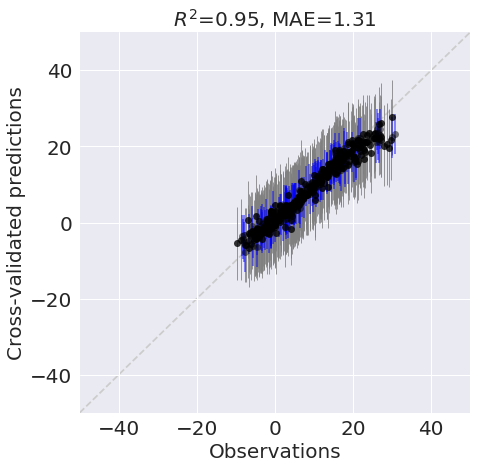

In [25]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=True,
                                 X_test=X_test, observed_test=y_test,
                                 xlim=[[-50, 50]], ylim=[[-50, 50]])

Train data:

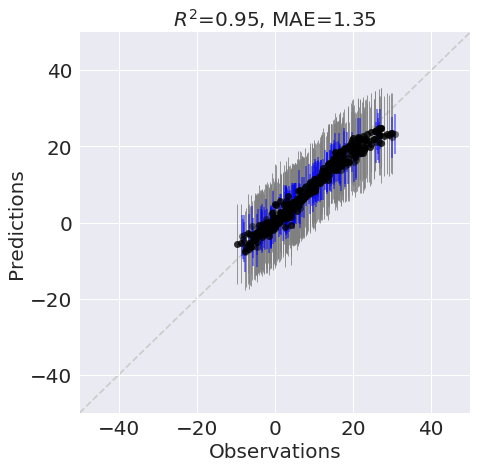

In [27]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=True,
                                 X_test=X_test, observed_test=y_test,
                                 xlim=[[-50, 50]], ylim=[[-50, 50]])

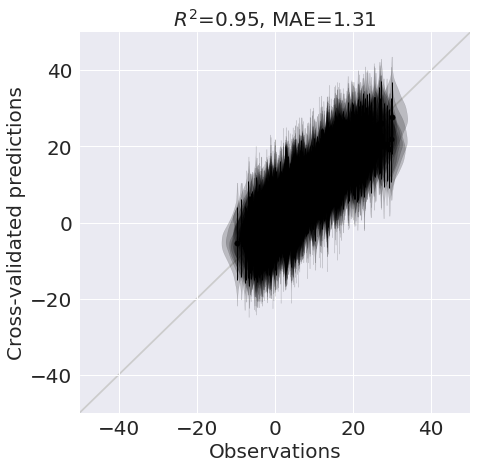

In [29]:
plot.predictions_distr_vs_observations(art, cv_flag=True, widths=8,
                                       xlim=[[-50, 50]], ylim=[[-50, 50]])

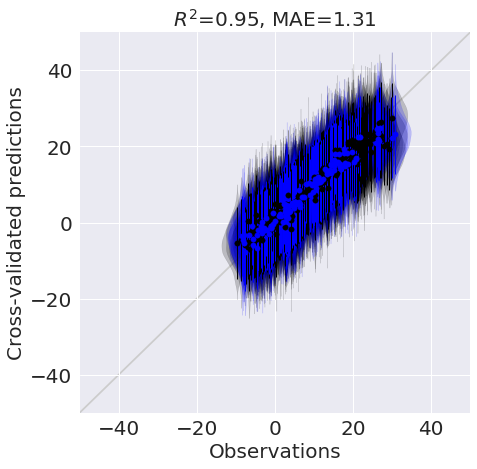

In [30]:
plot.predictions_distr_vs_observations(art, cv_flag=True, widths=8,
                                       X_test=X_test, observed_test=y_test,
                                       xlim=[[-50, 50]], ylim=[[-50, 50]])

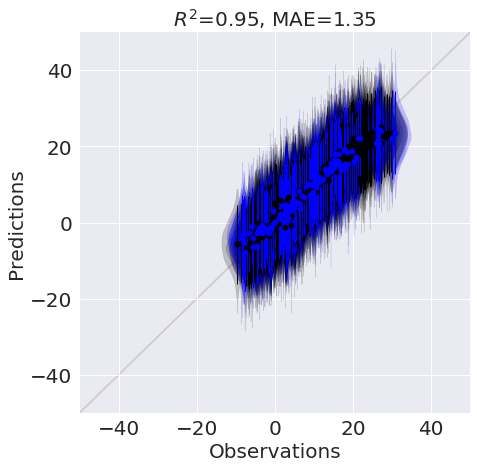

In [31]:
plot.predictions_distr_vs_observations(art, cv_flag=False, widths=8,
                                       X_test=X_test, observed_test=y_test,
                                       xlim=[[-50, 50]], ylim=[[-50, 50]])

In [32]:
os.rename(art.outDir + '/predictions_distr_vs_observations_cv_' + art.response_vars[0] + '.png',
          art.outDir + '/predictions_distr_vs_observations_cv_' + art.response_vars[0] + '_C1'
                                                                                          '.png')

os.rename(art.outDir + '/predictions_distr_vs_observations_cv_w_test_' + art.response_vars[0] +
          '.png',
          art.outDir + '/predictions_distr_vs_observations_cv_w_test_' + art.response_vars[0] +
          '_C1.png')


Plot the mean (lower triangle) and standard deviation (upper triangle) of the final model as functions of each pair of input varibles:

In [ ]:
# plot.model_pairwise(art)

Sample the space of protein expressions in search of those that maximize the limonene production.

Perform sampling-based optimization and find recommendations with default options (`niter=100000` for number of samples collected, `alpha=None` for a purely exploitative strategy, and `rel_rec_distance=20%` for relative recommendations distance) in a single line:

Finished 2.00 percent in 3.444331 s Acceptance rate = 0.441Adding DE jump with weight 20
Finished 99.00 percent in 108.509851 s Acceptance rate = 0.234081
Run Complete


time        CO       CO2        H2    acetate   biomass    butanol  \
0   5.932693  0.583090  0.197591  0.098620  86.581013  0.658679   4.891861   
1   5.786098  0.569670  0.188943  0.096091  94.420202  0.604567   8.600569   
2   5.886675  0.585714  0.187900  0.134177  86.220022  0.612766   4.573389   
3   5.363854  0.583472  0.182327  0.265335  95.800251  0.657933   4.759803   
4   5.595709  0.581056  0.182171  0.051771  96.214858  0.572716  13.475341   
5   5.677657  0.574888  0.177512  0.182488  91.222503  0.645779   7.985451   
6   5.708420  0.580049  0.216040  0.092298  92.388386  0.623588   8.038117   
7   5.392672  0.548811  0.190046  0.142898  97.568062  0.615069   7.654313   
8   5.900149  0.553087  0.175552  0.053917  93.463765  0.618557  11.274693   
9   5.748829  0.569353  0.199543  0.090763  96.648386  0.567252  12.902868   
10  5.935514  0.582380  0.239643  0.156082  92.059869  0.638357   7.028688   
11  5.890519  0.586333  0.278774  0.122576  91.665023  0.675617  12.206331   
12  5.895756  0.568276  0.218337  0.133503  94.163840  0.627738  11.049590   
13  5.584347  0.546243  0.201519  0.122490  97.193941  0.613725   6.473173   
14  5.879499  0.573193  0.230280  0.076836  93.994976  0.660071   5.604177   
15  5.481884  0.550795  0.177071  0.153413  96.465138  0.596367  10.693505   

     butyrate     ethanol  flow rate  ethanol_Δ  
0   11.695124  110.160110  20.391135  33.697516  
1   10.521525  109.768620  20.545223  33.508577  
2   12.125110  110.157946  20.493255  33.422446  
3   16.017702  110.371231  20.472530  33.275030  
4    4.859105  110.665433  20.577985  33.270901  
5   14.040447  110.406185  20.587236  33.269903  
6    7.425843  108.697721  20.677829  33.050308  
7   11.470821  109.424934  20.743055  33.040181  
8   10.766600  106.917821  20.540688  32.878090  
9    5.958056  108.239145  20.712334  32.786933  
10   8.503489  109.283117  20.286177  32.714757  
11  10.107915  108.897777  20.709732  32.685761  
12   9.455802  105.469535  20.504296  32.612147  
13   9.005268  104.824183  20.420649  32.570622  
14   5.196764  107.537625  20.319455  32.566980  
15  12.209296  109.737636  20.560770  32.554887

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


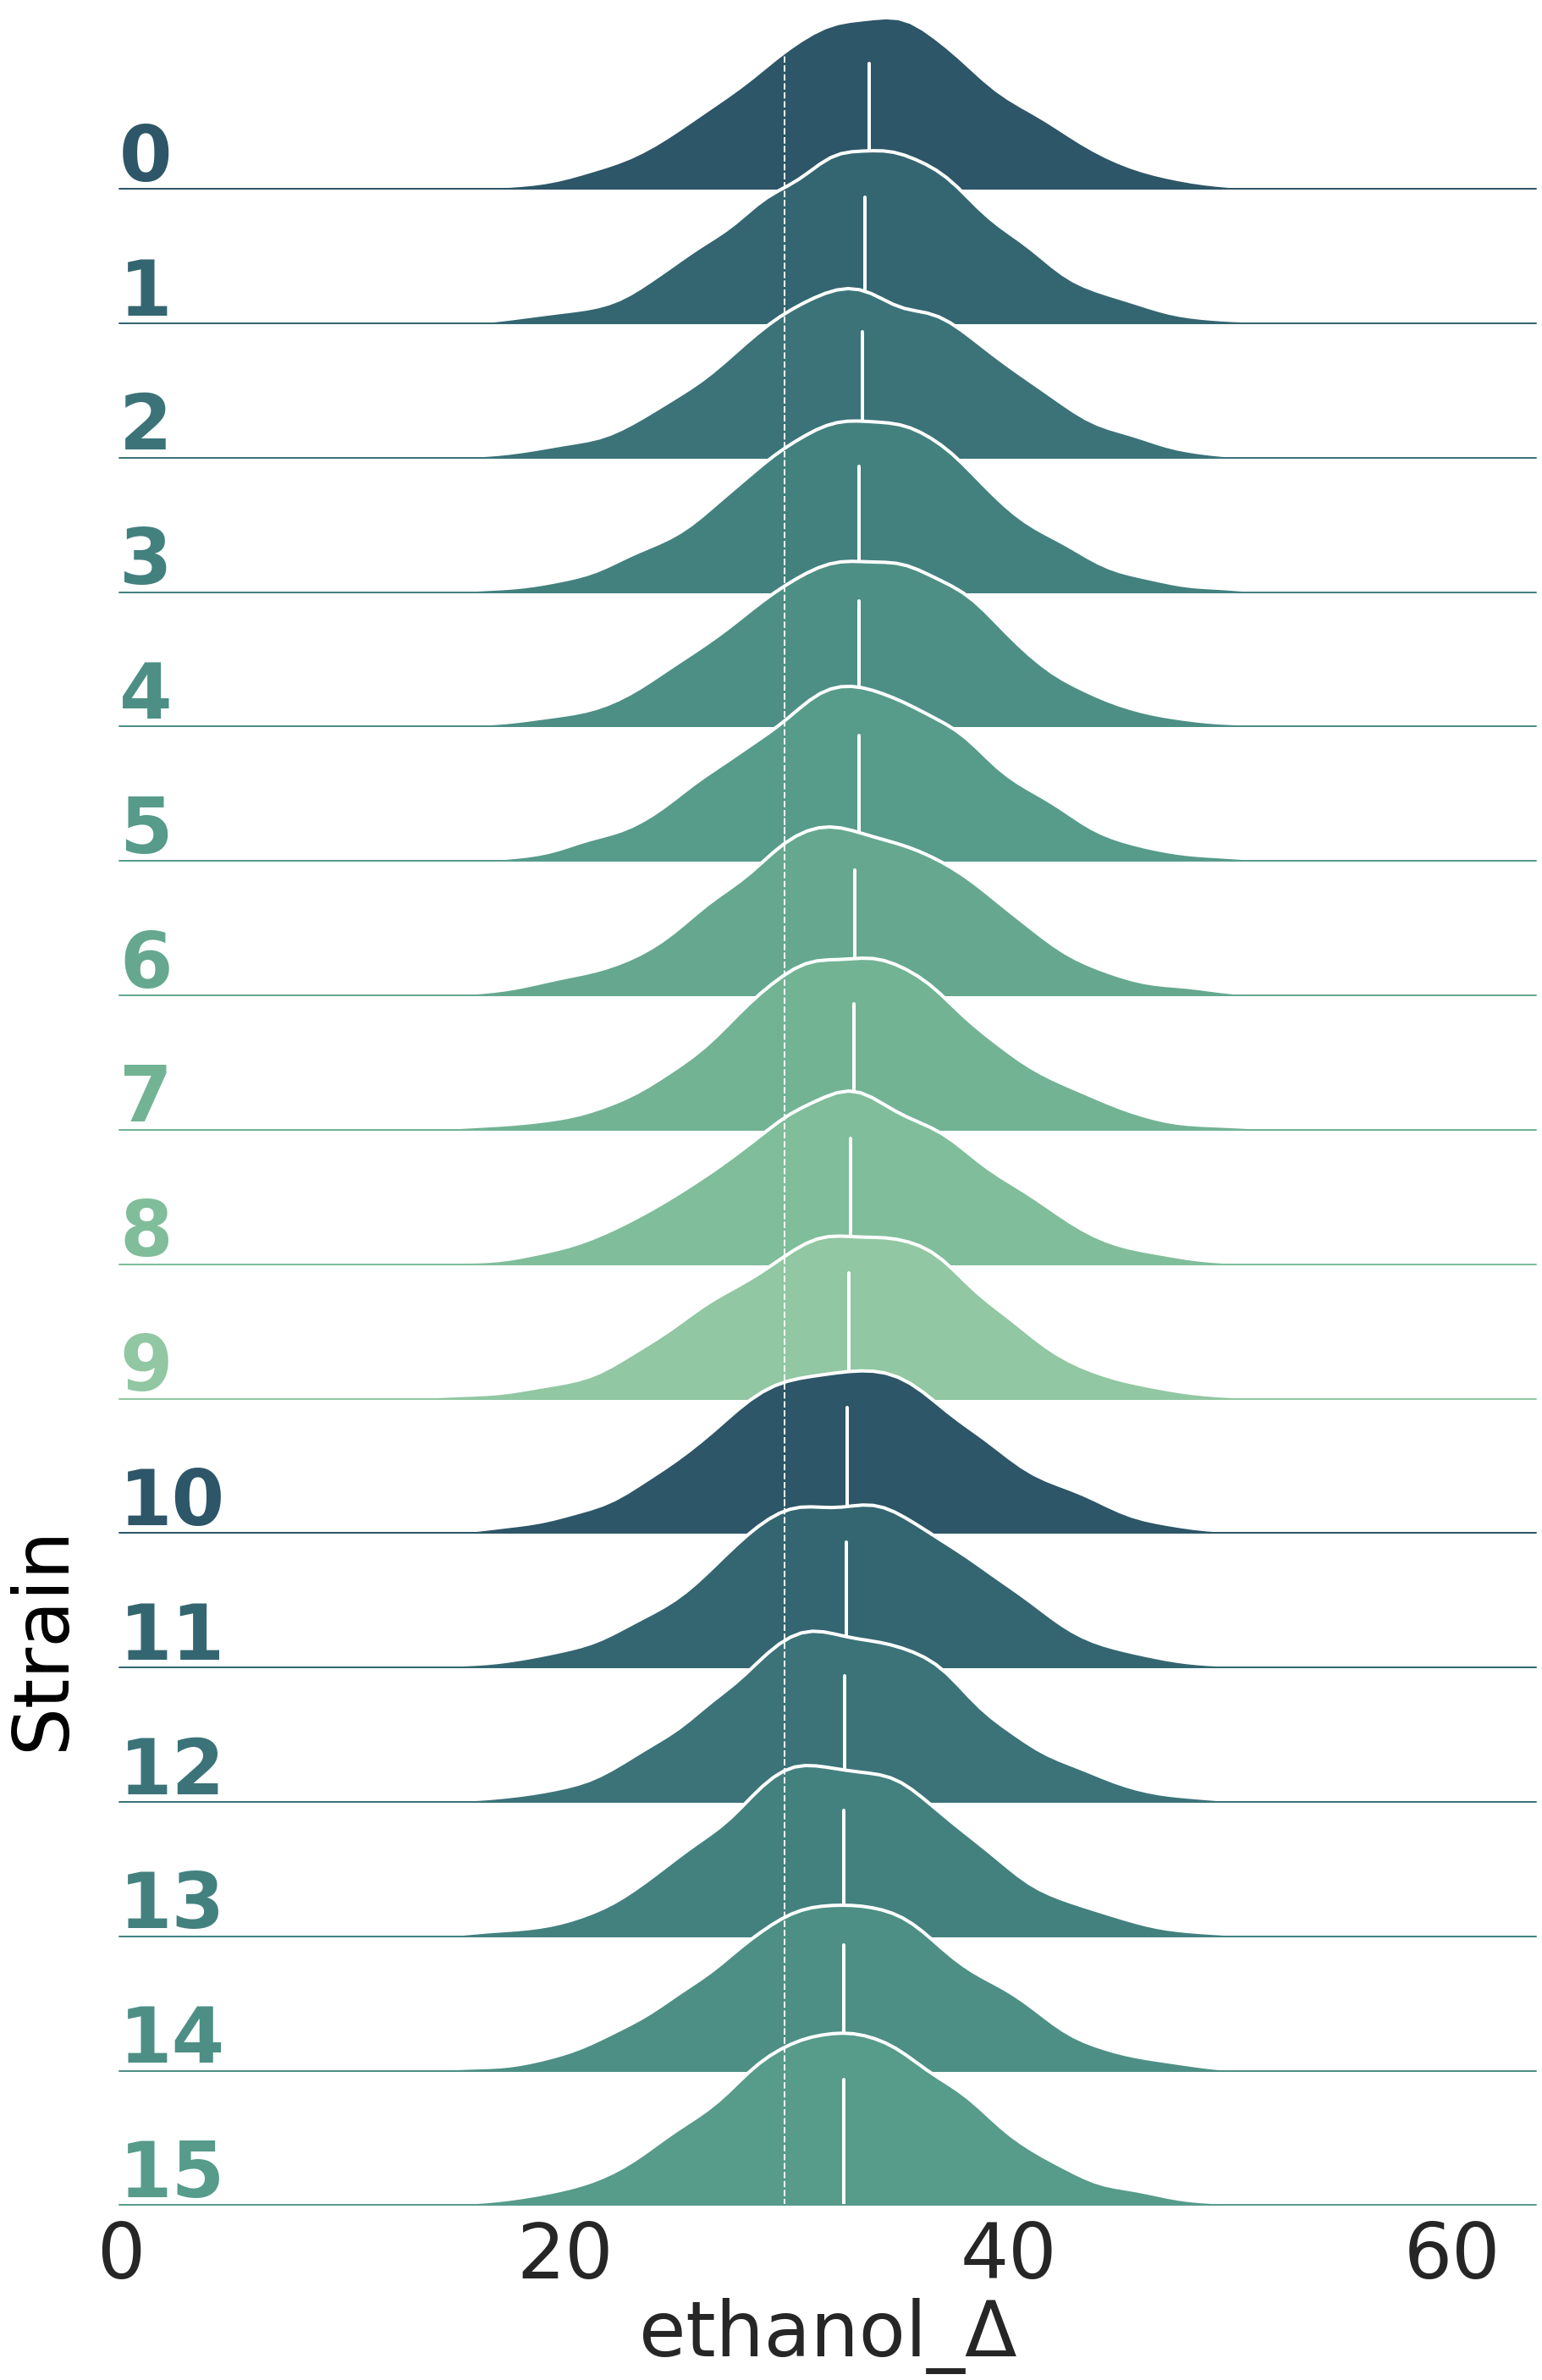

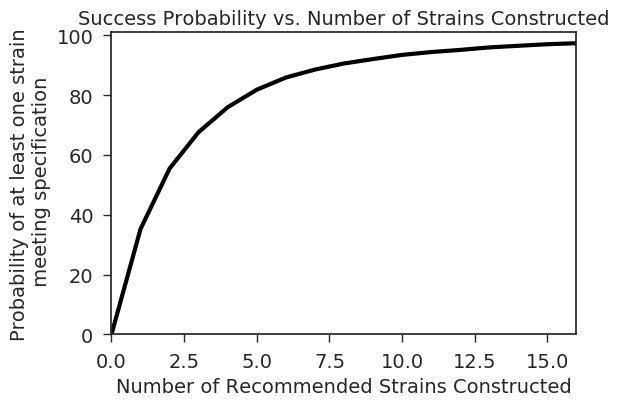

In [34]:
art.optimize()

In [35]:
os.rename(art.outDir + '/draws.txt',
          art.outDir + '/draws_niter100K_C1.txt')
os.rename(art.outDir + '/recommendations.csv',
          art.outDir + '/recommendations_niter100K_C1.csv')

Alternatively, find recommendations with user defined setting in two steps as:

In [36]:
art.niter = 1000000
draws = art.parallel_tempering_opt()

Finished 0.20 percent in 3.836730 s Acceptance rate = 0.491Adding DE jump with weight 20
Finished 99.90 percent in 1061.680760 s Acceptance rate = 0.225073
Run Complete


List recommendations that differ between each other relatively by the `art.rel_rec_distance` factor.


In [37]:
art.recommend(draws)

time        CO       CO2        H2    acetate   biomass    butanol  \
0   5.965287  0.572144  0.190101  0.178249  96.982370  0.664396   4.510153   
1   5.761727  0.569504  0.190570  0.092302  96.132819  0.653384   6.084168   
2   5.825658  0.567139  0.200406  0.114860  97.979508  0.652433   6.241323   
3   5.934843  0.584086  0.176197  0.066598  97.273208  0.623683   8.085197   
4   5.910162  0.559245  0.224487  0.089253  95.078786  0.631193   7.641616   
5   5.924230  0.586070  0.190610  0.149028  95.835901  0.637966  12.528326   
6   5.907391  0.579808  0.175981  0.091575  89.355412  0.602379   6.192461   
7   4.928536  0.586777  0.188120  0.079521  96.575828  0.685197   4.709118   
8   5.825383  0.535244  0.219300  0.166256  97.979257  0.661121   6.241404   
9   5.800947  0.566648  0.177023  0.118800  95.907708  0.586381   9.597331   
10  5.577000  0.574853  0.178926  0.092397  93.874188  0.677636  10.716009   
11  5.775434  0.583684  0.199281  0.073263  79.812493  0.629637   4.925839   
12  5.759083  0.573684  0.192941  0.146175  97.901381  0.677676  10.008751   
13  5.935145  0.556710  0.196638  0.188035  96.947564  0.680789   2.809942   
14  5.895095  0.585009  0.175621  0.231318  94.702498  0.638495   6.111757   
15  5.852051  0.574769  0.180509  0.124517  94.893839  0.679614   6.759132   

     butyrate     ethanol  flow rate  ethanol_Δ  
0   12.786904  109.126757  20.516823  34.273939  
1    8.814278  108.836332  20.642005  33.786980  
2   11.918503  110.682667  20.745072  33.726697  
3    7.742294  105.763639  20.354206  33.597348  
4    8.031959  109.329247  20.665267  33.451570  
5    8.120946  109.603009  20.740240  33.400770  
6   11.834213  108.717071  20.647257  33.393143  
7    8.508676  110.267016  20.636436  33.369382  
8   11.918454  110.682854  20.746219  33.339218  
9   11.233189  108.509202  20.578617  33.332216  
10  12.605393  108.800228  20.654448  33.266537  
11  11.849550  110.706132  20.614154  33.240362  
12  13.057591  107.663632  20.436792  33.238729  
13  12.300126  102.310701  20.584687  33.188397  
14  13.486817  102.063078  20.726021  33.167263  
15   7.333888  110.212895  20.619339  33.157055

(Neglected recommendations are those that do not satisfy the relative recommendations distance requirement)

The Table above provides a set of predictions which if followed should maximize the chance of successful strain engineering.

In [38]:
os.rename(art.outDir + '/draws.txt',
          art.outDir + '/draws_C1.txt')
os.rename(art.outDir + '/recommendations.csv',
          art.outDir + '/recommendations_C1.csv')

Visualize the predicted limonene production and the associated uncertainty (mean values are represented by vertical lines). Dashed lines is the production level for the best producing strain in the dataset.

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


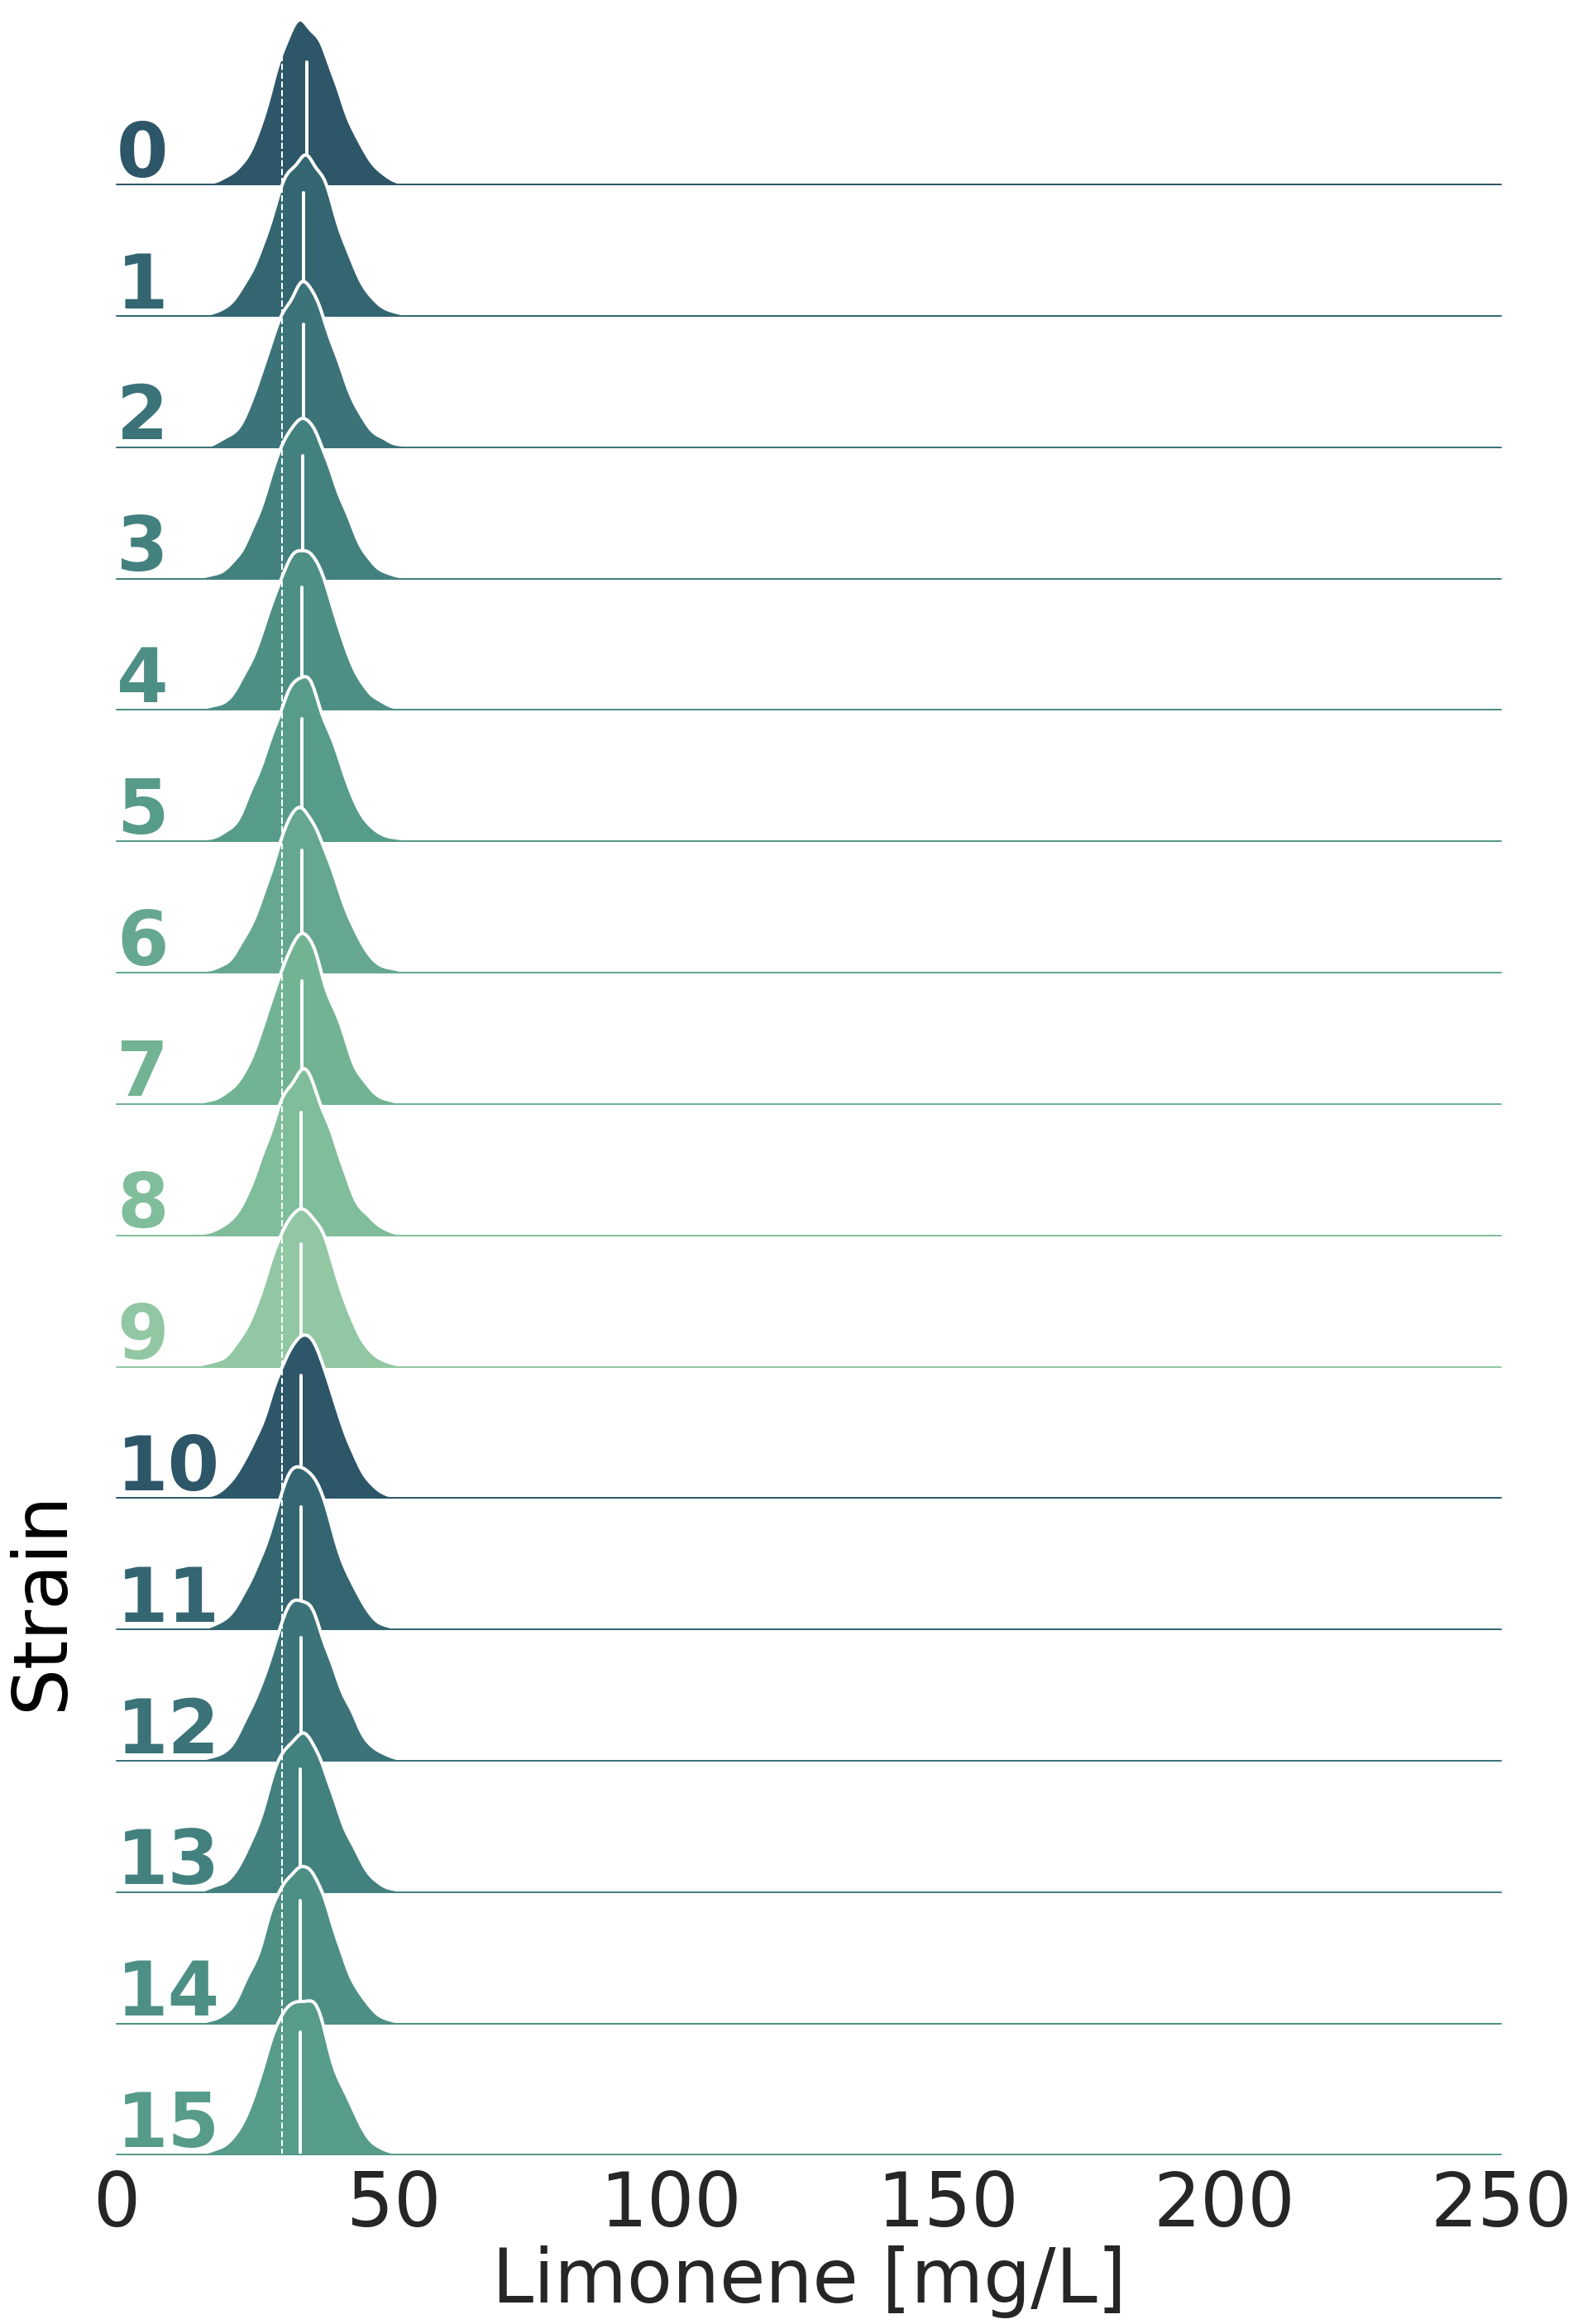

In [39]:
plot.recomm_distribution(art, art.find_current_best(), ['Limonene [mg/L]'], [0, 250])

Calculate and visualize the success probabilities if the recommended strains are being engineered.

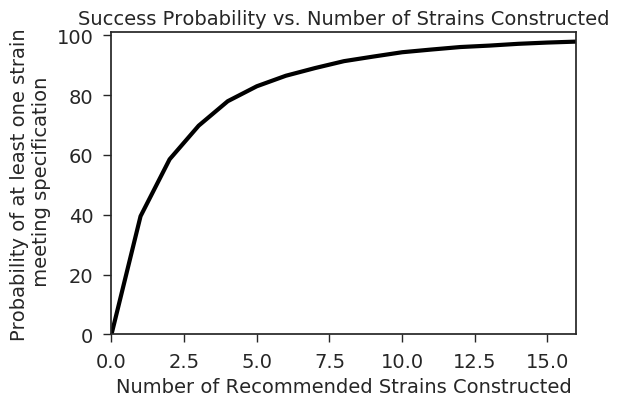

In [40]:
cumulative_success_prob = art.calculate_success_prob(current_best=art.find_current_best())
plot.success_prob(art, cumulative_success_prob)

In [41]:
os.rename(art.outDir + '/recommendations_distribution_0.png',
          art.outDir + '/recommendations_distribution_C1.png')
os.rename(art.outDir + '/success_probability_' + art.response_vars[0] + '.png',
          art.outDir + '/success_probability_' + art.response_vars[0] + '_C1.png')

Plot first two principal components of draws (top) and recommendations (bottom) (in green) with observed data (in red)

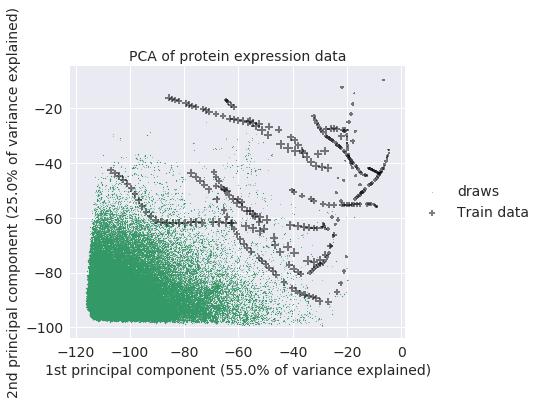

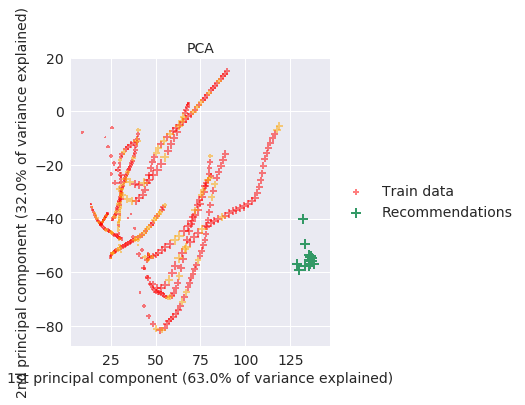

In [42]:
plot.draws_pc(art, draws, scale=3, plot_draws=True, plot_kde=False)
plot.recommendations_pc(art, scale=3, X_test=X_test, objective_value_y_test=y_test)


Heatmap of the mean of the final model as function of the two principal components of input varibles:

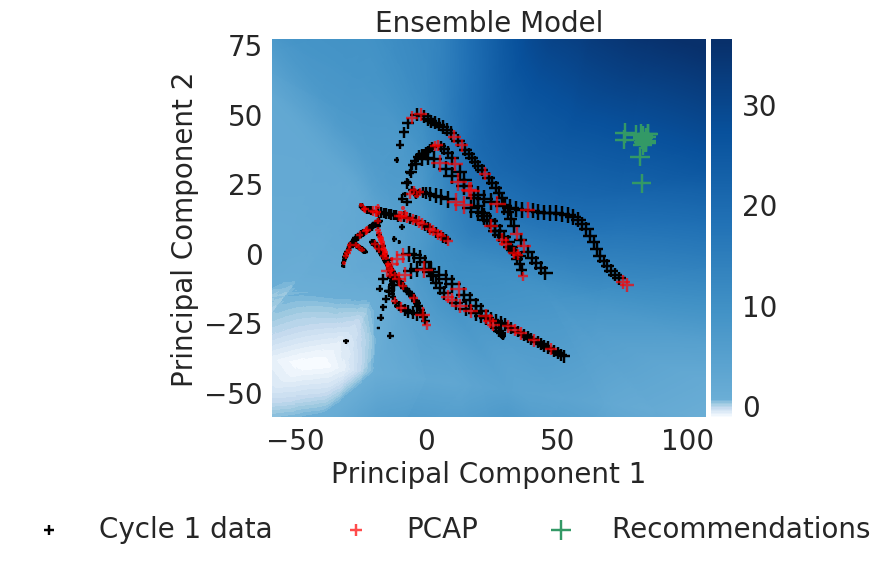

In [43]:
model = art
plot.plot_model(model, art, X_test, y_test, scaling_factor=1.5,
                midpoint=0.6,
                title='Ensemble Model', plot_points=True)


In [44]:
os.rename(art.outDir + '/Ensemble Model_model.png',
          art.outDir + '/Ensemble Model_model_C1.png')

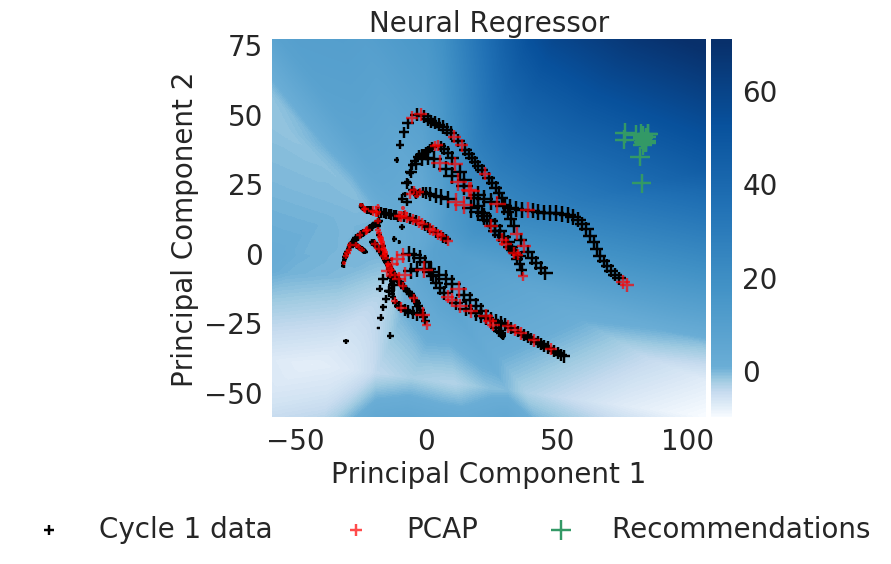

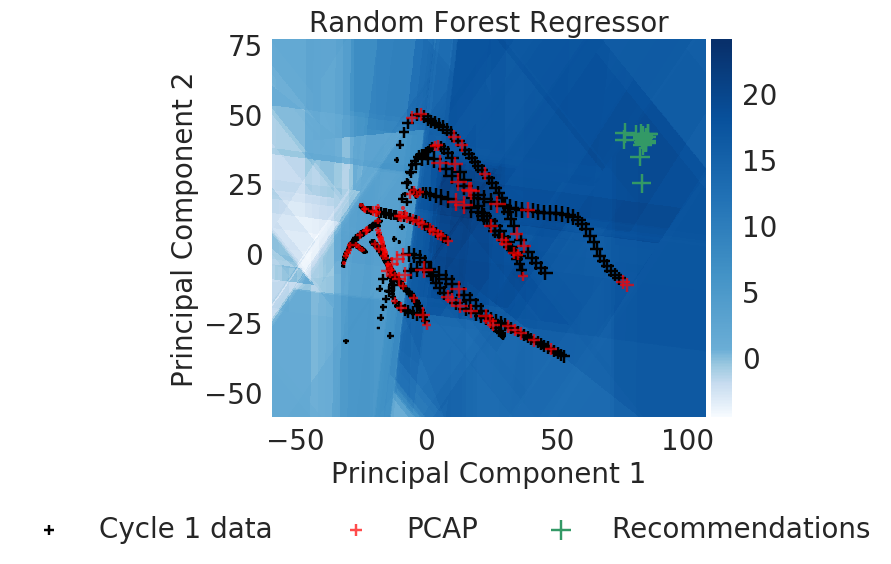

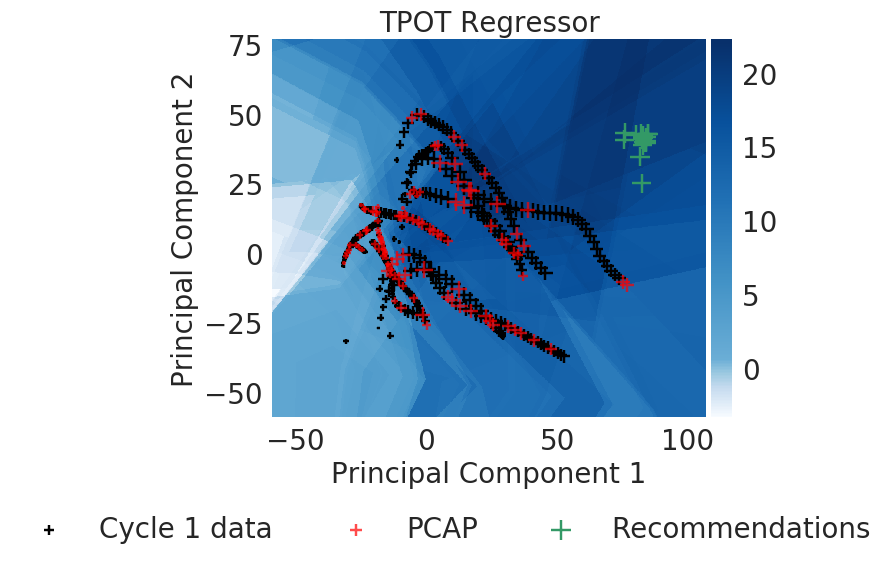

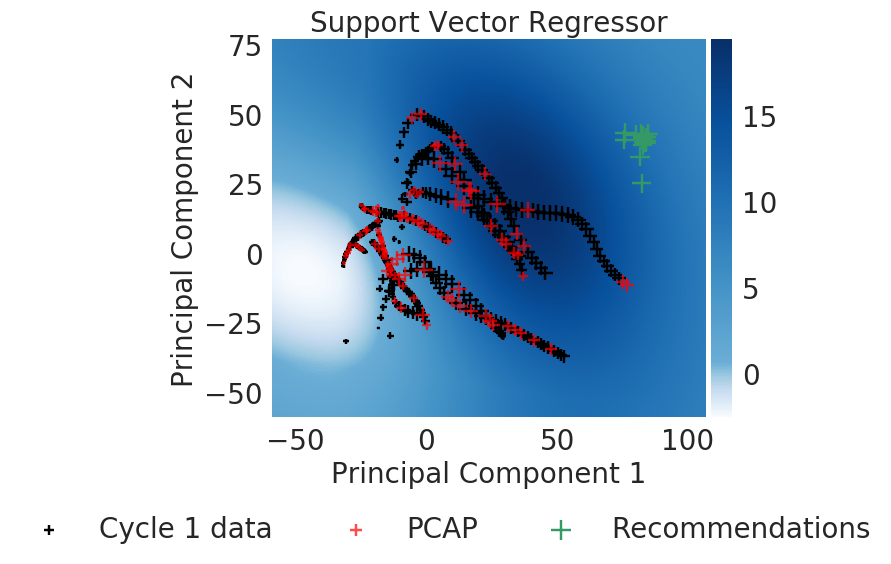

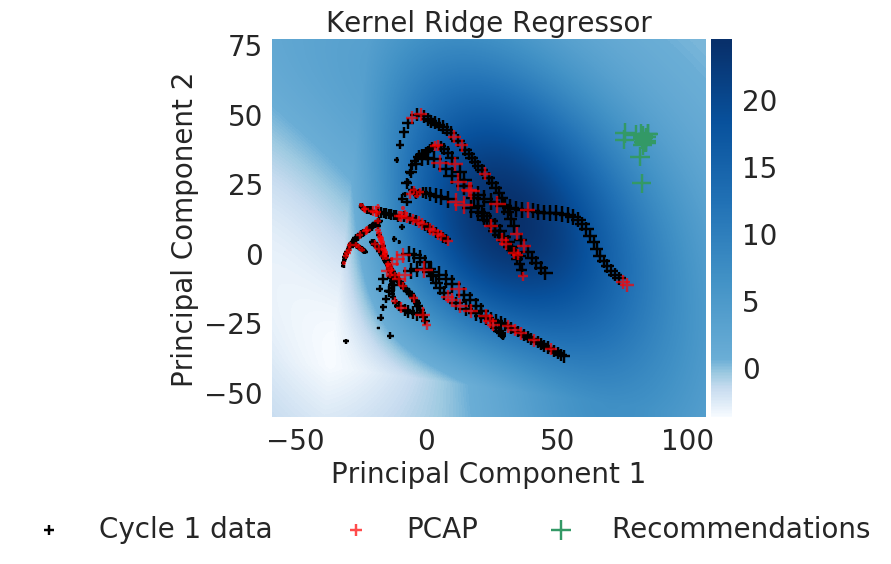

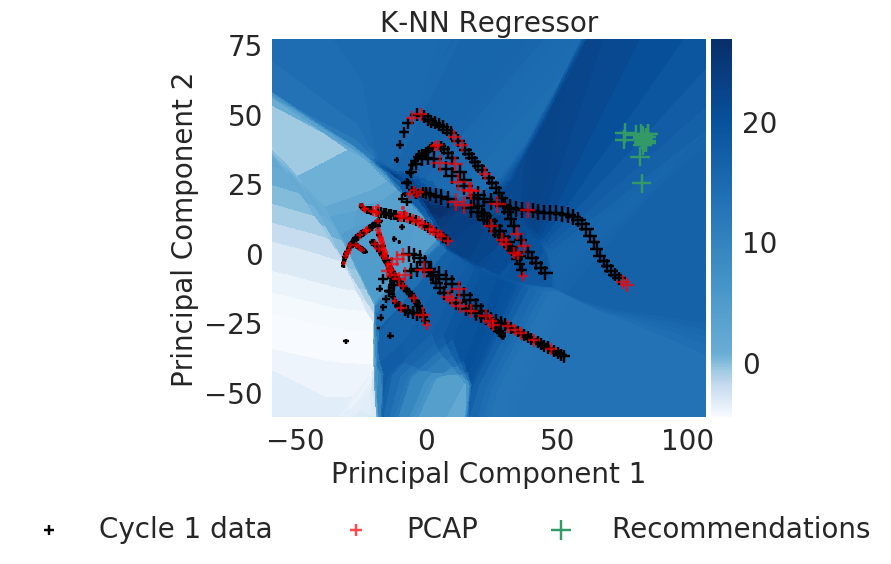

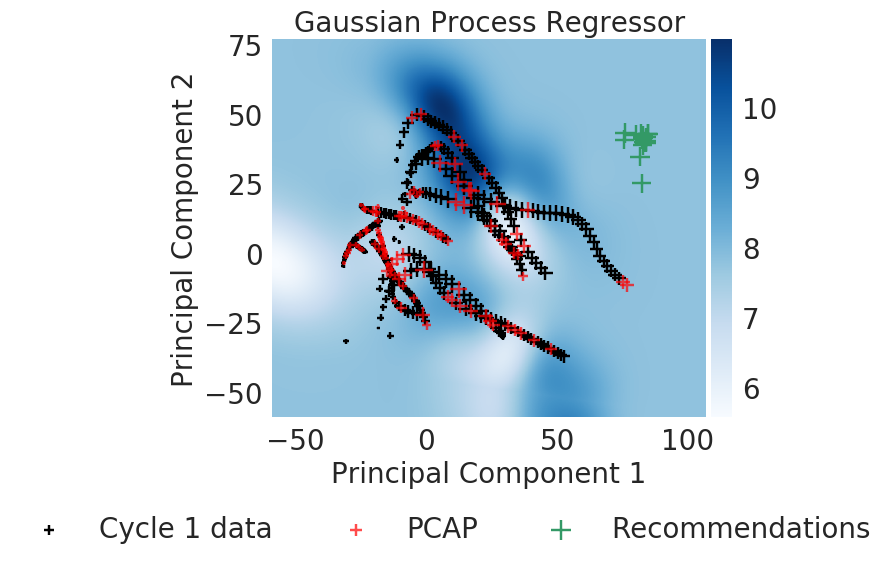

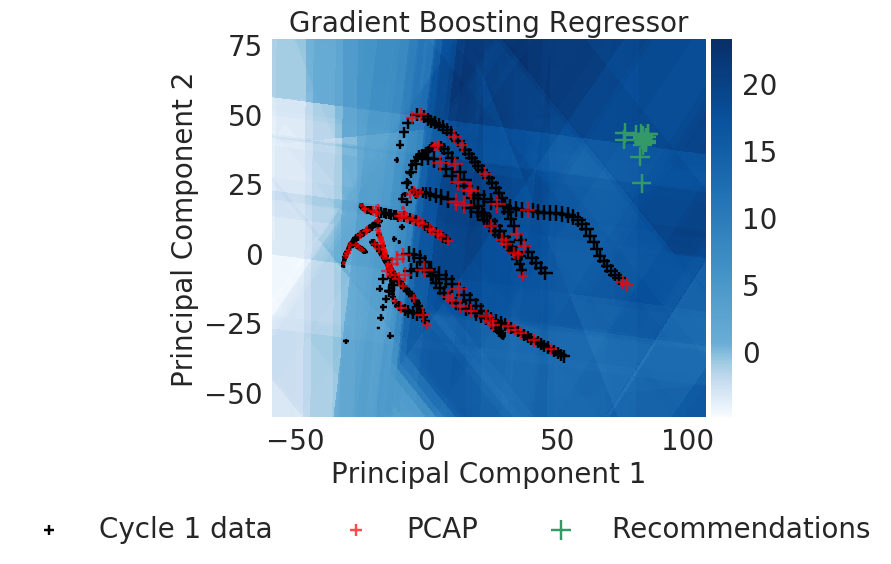

In [45]:
titles = ['Neural Regressor',
          'Random Forest Regressor',
          'TPOT Regressor',
          'Support Vector Regressor',
          'Kernel Ridge Regressor',
          'K-NN Regressor',
          'Gaussian Process Regressor',
          'Gradient Boosting Regressor']

for model,title in zip(art.model_df[0]['Model'][:-1],titles):
    plot.plot_model(model, art, X_test, y_test, scaling_factor=1.5,
               midpoint=0.6, title=title, plot_points=True)


Visualize input data pairwise. The size of each point represents the level of output variable (limonene production).

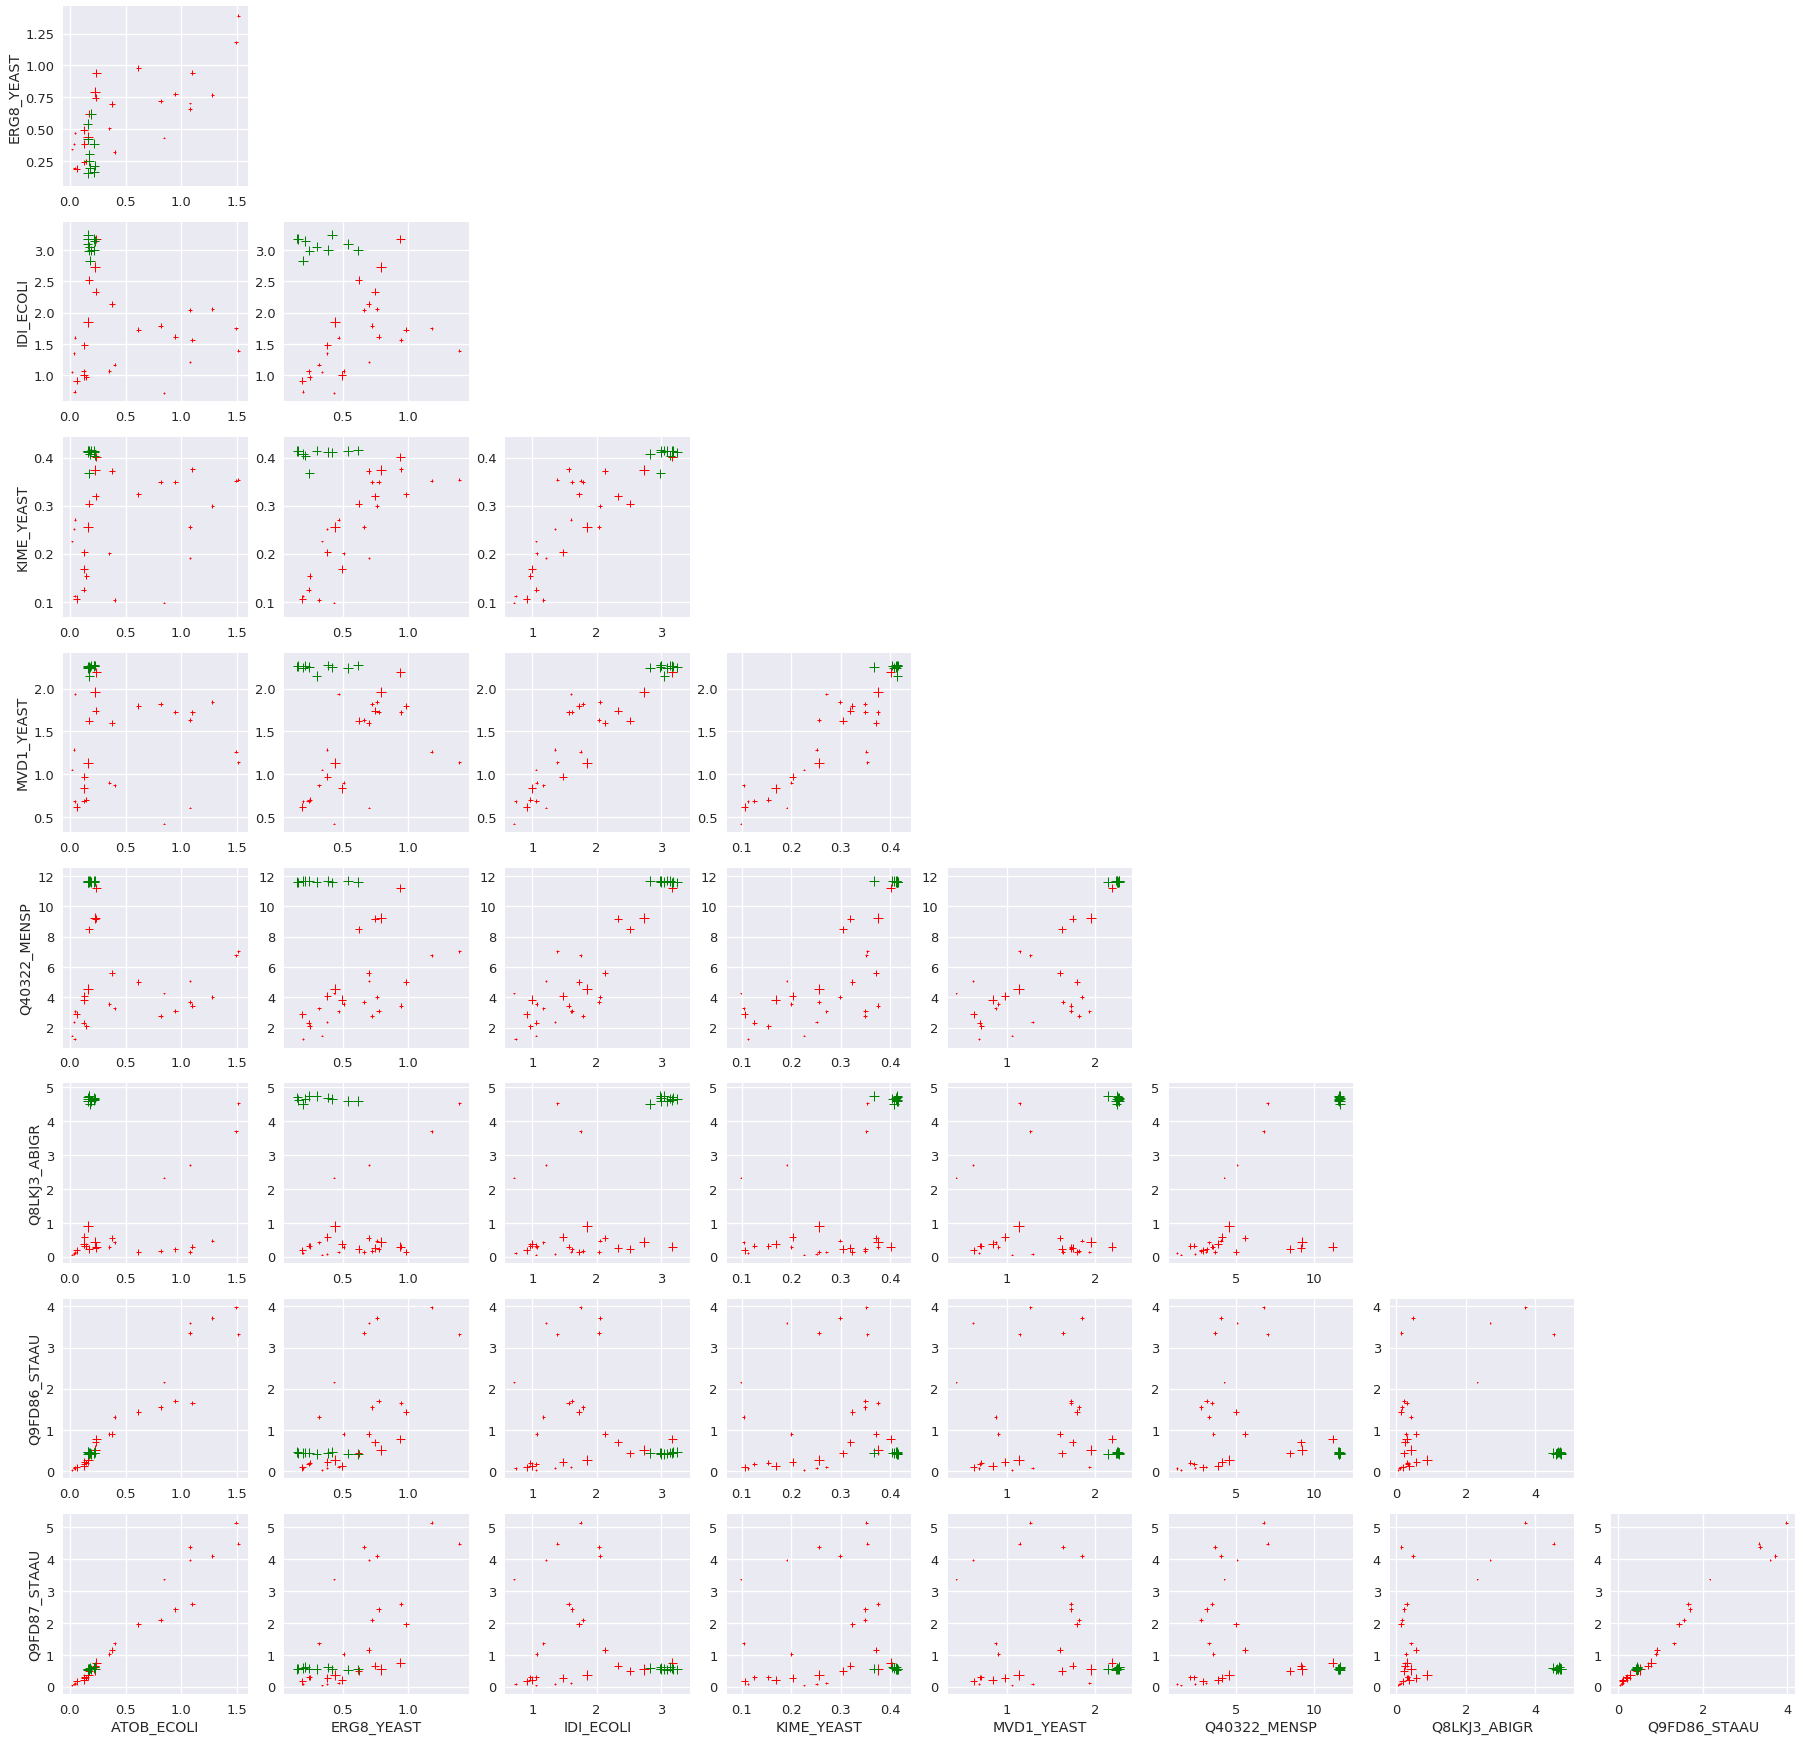

In [41]:
plot.data_pairwise(art, recommendations=art.recommendations)

In [42]:
utils.save_pkl_object(art)

In [43]:
os.rename(art.outDir + '/art.pkl', art.outDir + '/art_C1.pkl')

## Recommend strains for the next DBTL cycle

Repeat the process by including all data points.

In [44]:
# art_params['cross_val'] = True

In [ ]:
art2 = RecommendationEngine(df, **art_params)

Best pipeline: RidgeCV(DecisionTreeRegressor(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=average), DecisionTreeRegressor__max_depth=4, DecisionTreeRegressor__min_samples_leaf=13, DecisionTreeRegressor__min_samples_split=14))


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:20<00:00, 1081.50draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


MAE     MRAE(%)      StdAE           MSE  \
Name                                                                          
Neural Regressor              0.097560    0.990360   0.222568  5.905438e-02   
Random Forest Regressor       9.768798   65.567237   8.755191  1.720828e+02   
TPOT Regressor               15.493968  119.417013  13.047534  4.103012e+02   
Support Vector Regressor     25.816751  151.889853  28.865585  1.499727e+03   
Kernel Ridge Regressor       12.574144   82.423719  11.951892  3.009568e+02   
K-NN Regressor               14.385255  102.244064  14.015780  4.033776e+02   
Gaussian Process Regressor    0.000021    0.000213   0.000014  6.456474e-10   
Gradient Boosting Regressor   0.103705    1.008630   0.083743  1.776753e-02   
Ensemble Model               10.466518   69.649149   9.940372  2.083590e+02   

                                $R^2$  
Name                                   
Neural Regressor             0.999956  
Random Forest Regressor      0.872514  
TPOT Regressor               0.696031  
Support Vector Regressor    -0.111063  
Kernel Ridge Regressor       0.777038  
K-NN Regressor               0.701160  
Gaussian Process Regressor   1.000000  
Gradient Boosting Regressor  0.999987  
Ensemble Model               0.845638

Finished 2.00 percent in 2.386322 s Acceptance rate = 0.316Adding DE jump with weight 20
Finished 99.00 percent in 95.655656 s Acceptance rate = 0.230838
Run Complete


ATOB_ECOLI  ERG8_YEAST  IDI_ECOLI  KIME_YEAST  MVD1_YEAST  Q40322_MENSP  \
0    0.218342    0.260281   2.491320    1.480789    4.063428     14.112370   
1    0.234206    0.186433   2.631791    1.466854    4.079612     14.040201   
2    0.241177    0.593763   2.635061    1.476942    3.974173     14.200707   
3    0.241057    0.446392   2.430833    1.351156    4.218492     13.962244   
4    0.311280    0.541223   2.625381    1.403694    4.035341     14.167358   
5    0.249659    0.143297   2.572427    1.477782    4.085782     13.607532   
6    0.258514    0.496217   1.868473    1.471325    4.085621     14.142297   
7    0.281085    0.212649   2.466410    1.348570    4.124726     13.888037   
8    0.233142    0.330961   2.517194    1.448379    4.214362     13.728017   
9    0.218596    0.159485   2.460587    1.155999    3.860295     13.853541   

   Q8LKJ3_ABIGR  Q9FD86_STAAU  Q9FD87_STAAU  \
0      4.740141      0.440511      0.542264   
1      4.735709      0.425831      0.582515   
2      4.744894      0.449222      0.542008   
3      4.731818      0.420172      0.547300   
4      4.705895      0.434928      0.542202   
5      4.708181      0.418856      0.555863   
6      4.747490      0.417627      0.578515   
7      4.737759      0.436761      0.558939   
8      4.733667      0.442724      0.575529   
9      4.737678      0.424737      0.542023   

   4-isopropenyl-1-methyl-cyclohexene  
0                          123.420252  
1                          123.257852  
2                          123.228856  
3                          123.045569  
4                          122.710899  
5                          122.550819  
6                          122.378148  
7                          122.357037  
8                          122.326542  
9                          122.297105

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


In [46]:
art2.build_model()

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RidgeCV(CombineDFs(input_matrix, PolynomialFeatures(input_matrix, PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=DEFAULT, PolynomialFeatures__interaction_only=False)))


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False i

Best pipeline: LassoLarsCV(PCA(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.3), PCA__iterated_power=DEFAULT, PCA__svd_solver=randomized), LassoLarsCV__normalize=False)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

Best pipeline: RidgeCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=average))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1008.60draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8816136330481692, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: LinearSVR(input_matrix, LinearSVR__C=25.0, LinearSVR__dual=True, LinearSVR__epsilon=0.1, LinearSVR__loss=DEFAULT, LinearSVR__tol=0.01)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 905.51draws/s]
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:26<00:00, 830.69draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class name

Best pipeline: RandomForestRegressor(RidgeCV(Normalizer(input_matrix, Normalizer__norm=l1)), RandomForestRegressor__bootstrap=DEFAULT, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=4, RandomForestRegressor__min_samples_split=4, RandomForestRegressor__n_estimators=100)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:22<00:00, 962.99draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RidgeCV(VarianceThreshold(PCA(input_matrix, PCA__iterated_power=10, PCA__svd_solver=randomized), VarianceThreshold__threshold=0.5))


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 914.28draws/s] 
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: ElasticNetCV(PolynomialFeatures(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=cosine, FeatureAgglomeration__linkage=complete), PolynomialFeatures__degree=DEFAULT, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=False), ElasticNetCV__l1_ratio=0.15000000000000002, ElasticNetCV__tol=0.0001)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

Best pipeline: ElasticNetCV(KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=1, KNeighborsRegressor__p=DEFAULT, KNeighborsRegressor__weights=distance), ElasticNetCV__l1_ratio=0.1, ElasticNetCV__tol=0.0001)


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/li

MAE     MRAE(%)      StdAE     $R^2$
Name                                                                   
Neural Regressor             20.783169  110.313877  20.948431  0.354890
Random Forest Regressor      22.429269  203.616382  19.106541  0.356850
TPOT Regressor               19.373528  122.496028  17.499054  0.495077
Support Vector Regressor     27.350860  167.500699  29.190907 -0.185483
Kernel Ridge Regressor       20.304178  115.537782  23.297712  0.292462
K-NN Regressor               18.444413  150.032013  17.981583  0.508425
Gaussian Process Regressor   27.571575  267.617494  21.815826  0.084226
Gradient Boosting Regressor  17.517936  143.540533  17.502119  0.545713
Ensemble Model               17.577829  120.002281  14.884817  0.606954

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Best pipeline: RidgeCV(FeatureAgglomeration(input_matrix, FeatureAgglomeration__affinity=precomputed, FeatureAgglomeration__linkage=complete))


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:29<00:00, 739.66draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


MAE       MRAE(%)         StdAE  \
Name                                                                    
Neural Regressor             9.755980e-02  9.903602e-01  2.225679e-01   
Random Forest Regressor      9.768798e+00  6.556724e+01  8.755191e+00   
TPOT Regressor               1.501990e+01  1.139228e+02  1.383427e+01   
Support Vector Regressor     2.581675e+01  1.518899e+02  2.886558e+01   
Kernel Ridge Regressor       1.257414e+01  8.242372e+01  1.195189e+01   
K-NN Regressor               1.438525e+01  1.022441e+02  1.401578e+01   
Gaussian Process Regressor   6.713831e-10  6.801025e-09  4.551647e-10   
Gradient Boosting Regressor  1.037050e-01  1.008630e+00  8.374255e-02   
Ensemble Model               1.088003e+01  7.101156e+01  1.074459e+01   

                                      MSE     $R^2$  
Name                                                 
Neural Regressor             5.905438e-02  0.999956  
Random Forest Regressor      1.720828e+02  0.872514  
TPOT Regressor               4.169845e+02  0.691080  
Support Vector Regressor     1.499727e+03 -0.111063  
Kernel Ridge Regressor       3.009568e+02  0.777038  
K-NN Regressor               4.033776e+02  0.701160  
Gaussian Process Regressor   6.579301e-19  1.000000  
Gradient Boosting Regressor  1.776753e-02  0.999987  
Ensemble Model               2.338211e+02  0.826775

In [47]:
art2.evaluate_models_cv()

MAE     MRAE(%)      StdAE          MSE  \
Name                                                                         
Neural Regressor             20.783169  110.313877  20.948431   870.776845   
Random Forest Regressor      22.429269  203.616382  19.106541   868.132024   
TPOT Regressor               19.373528  122.496028  17.499054   681.550459   
Support Vector Regressor     27.350860  167.500699  29.190907  1600.178560   
Kernel Ridge Regressor       20.304178  115.537782  23.297712   955.043003   
K-NN Regressor               18.444413  150.032013  17.981583   663.533698   
Gaussian Process Regressor   27.571575  267.617494  21.815826  1236.122027   
Gradient Boosting Regressor  17.517936  143.540533  17.502119   613.202227   
Ensemble Model               17.577829  120.002281  14.884817   530.537838   

                                $R^2$  
Name                                   
Neural Regressor             0.354890  
Random Forest Regressor      0.356850  
TPOT Regressor               0.495077  
Support Vector Regressor    -0.185483  
Kernel Ridge Regressor       0.292462  
K-NN Regressor               0.508425  
Gaussian Process Regressor   0.084226  
Gradient Boosting Regressor  0.545713  
Ensemble Model               0.606954

In [48]:
art2.evaluate_models()

MAE       MRAE(%)         StdAE  \
Name                                                                    
Neural Regressor             9.755980e-02  9.903602e-01  2.225679e-01   
Random Forest Regressor      9.768798e+00  6.556724e+01  8.755191e+00   
TPOT Regressor               1.501990e+01  1.139228e+02  1.383427e+01   
Support Vector Regressor     2.581675e+01  1.518899e+02  2.886558e+01   
Kernel Ridge Regressor       1.257414e+01  8.242372e+01  1.195189e+01   
K-NN Regressor               1.438525e+01  1.022441e+02  1.401578e+01   
Gaussian Process Regressor   6.713831e-10  6.801025e-09  4.551647e-10   
Gradient Boosting Regressor  1.037050e-01  1.008630e+00  8.374255e-02   
Ensemble Model               1.088003e+01  7.101156e+01  1.074459e+01   

                                      MSE     $R^2$  
Name                                                 
Neural Regressor             5.905438e-02  0.999956  
Random Forest Regressor      1.720828e+02  0.872514  
TPOT Regressor               4.169845e+02  0.691080  
Support Vector Regressor     1.499727e+03 -0.111063  
Kernel Ridge Regressor       3.009568e+02  0.777038  
K-NN Regressor               4.033776e+02  0.701160  
Gaussian Process Regressor   6.579301e-19  1.000000  
Gradient Boosting Regressor  1.776753e-02  0.999987  
Ensemble Model               2.338211e+02  0.826775

In [49]:
os.rename(art2.outDir + '/cv_metric0.csv', art2.outDir + '/cv_metric_C2.csv')

os.rename(art2.outDir + '/metric0.csv', art2.outDir + '/metric_C2.csv')

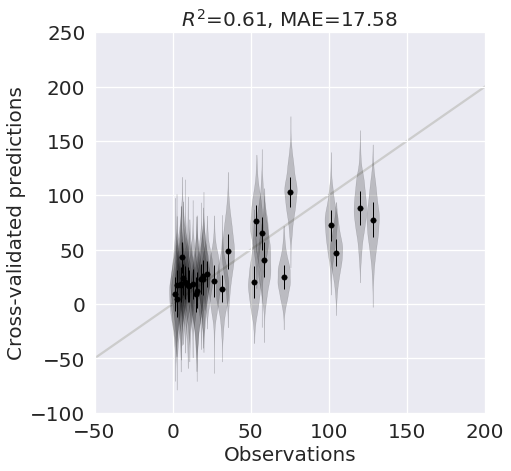

In [50]:
plot.predictions_distr_vs_observations(art2, cv_flag=True, widths=8,
                                       xlim=[[-50, 200]], ylim=[[-100, 250]])


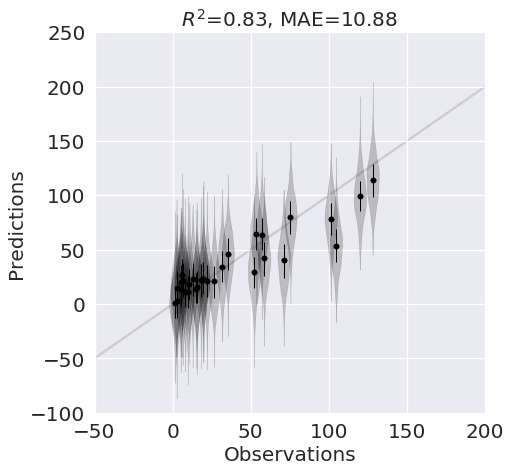

In [51]:
plot.predictions_distr_vs_observations(art2, cv_flag=False, widths=8,
                                       xlim=[[-50, 200]], ylim=[[-100, 250]])


In [52]:
os.rename(art2.outDir + '/predictions_distr_vs_observations_cv_' + art2.response_vars[0] + '.png',
          art2.outDir + '/predictions_distr_vs_observations_cv_' + art2.response_vars[0] + '_C2'
                                                                                           '.png')


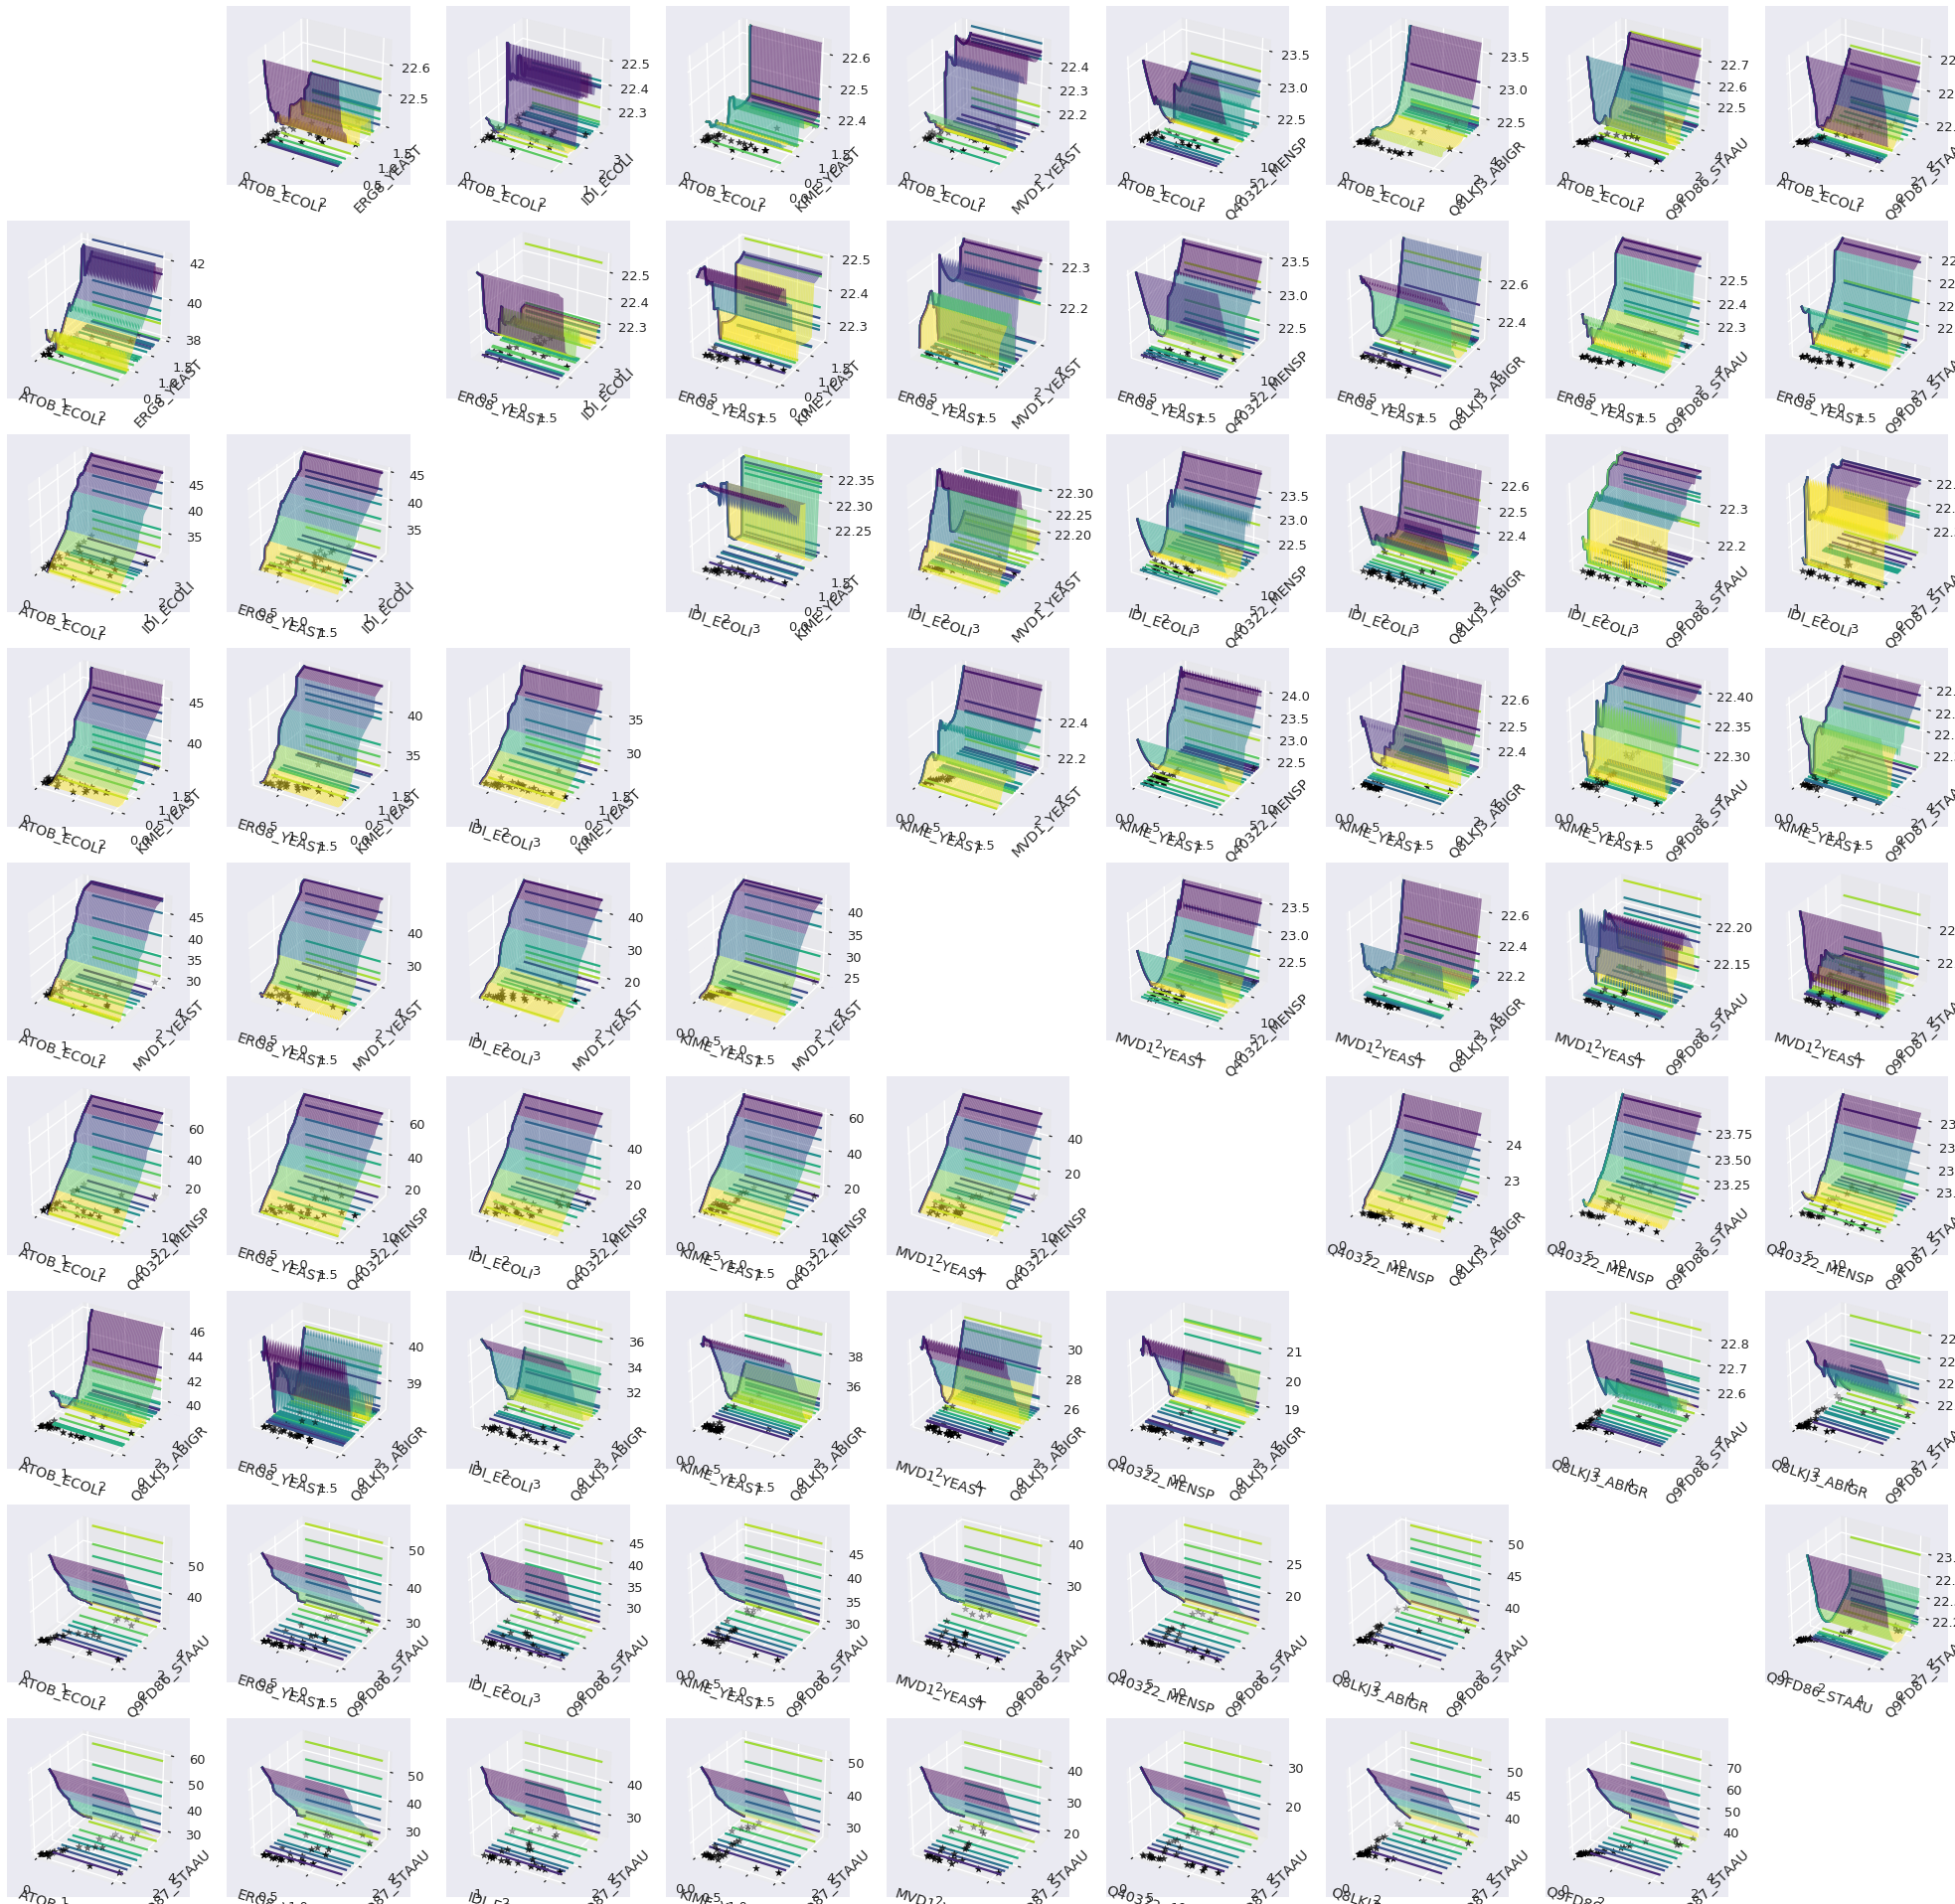

In [53]:
plot.model_pairwise(art2, cycle=2)

Finished 0.20 percent in 2.330396 s Acceptance rate = 0.3395Adding DE jump with weight 20
Finished 99.90 percent in 902.069278 s Acceptance rate = 0.227065
Run Complete


ATOB_ECOLI  ERG8_YEAST  IDI_ECOLI  KIME_YEAST  MVD1_YEAST  Q40322_MENSP  \
0    0.234199    0.487832   3.266316    1.386211    4.283460     14.186066   
1    0.304430    0.448369   3.267455    1.423258    4.120012     14.176944   
2    0.250259    0.296728   3.246714    1.417990    4.280607     14.154497   
3    0.231968    0.225153   2.654609    1.421253    4.094385     14.140918   
4    0.265392    0.668895   3.275770    1.414004    4.136469     14.176550   
5    0.219292    0.369854   2.655667    1.461998    4.279992     13.896931   
6    0.407389    0.437112   2.624322    1.474782    3.970152     14.132254   
7    0.231927    0.450279   2.597221    1.481615    4.111077     14.155387   
8    0.231595    0.207243   3.273679    1.244119    4.225936     14.211947   
9    0.360115    0.344735   2.556731    1.367727    4.159018     14.155705   

   Q8LKJ3_ABIGR  Q9FD86_STAAU  Q9FD87_STAAU  \
0      4.692659      0.426682      0.564265   
1      4.715317      0.440042      0.538999   
2      4.722770      0.420765      0.578563   
3      4.741337      0.442388      0.545122   
4      4.736507      0.437243      0.539060   
5      4.743357      0.442745      0.551661   
6      4.699904      0.417834      0.540473   
7      4.748776      0.429450      0.612102   
8      4.732918      0.441100      0.539292   
9      4.717482      0.418328      0.541121   

   4-isopropenyl-1-methyl-cyclohexene  
0                          119.280547  
1                          119.180583  
2                          119.153228  
3                          119.142625  
4                          119.071354  
5                          119.052375  
6                          118.974516  
7                          118.959371  
8                          118.897316  
9                          118.760481

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


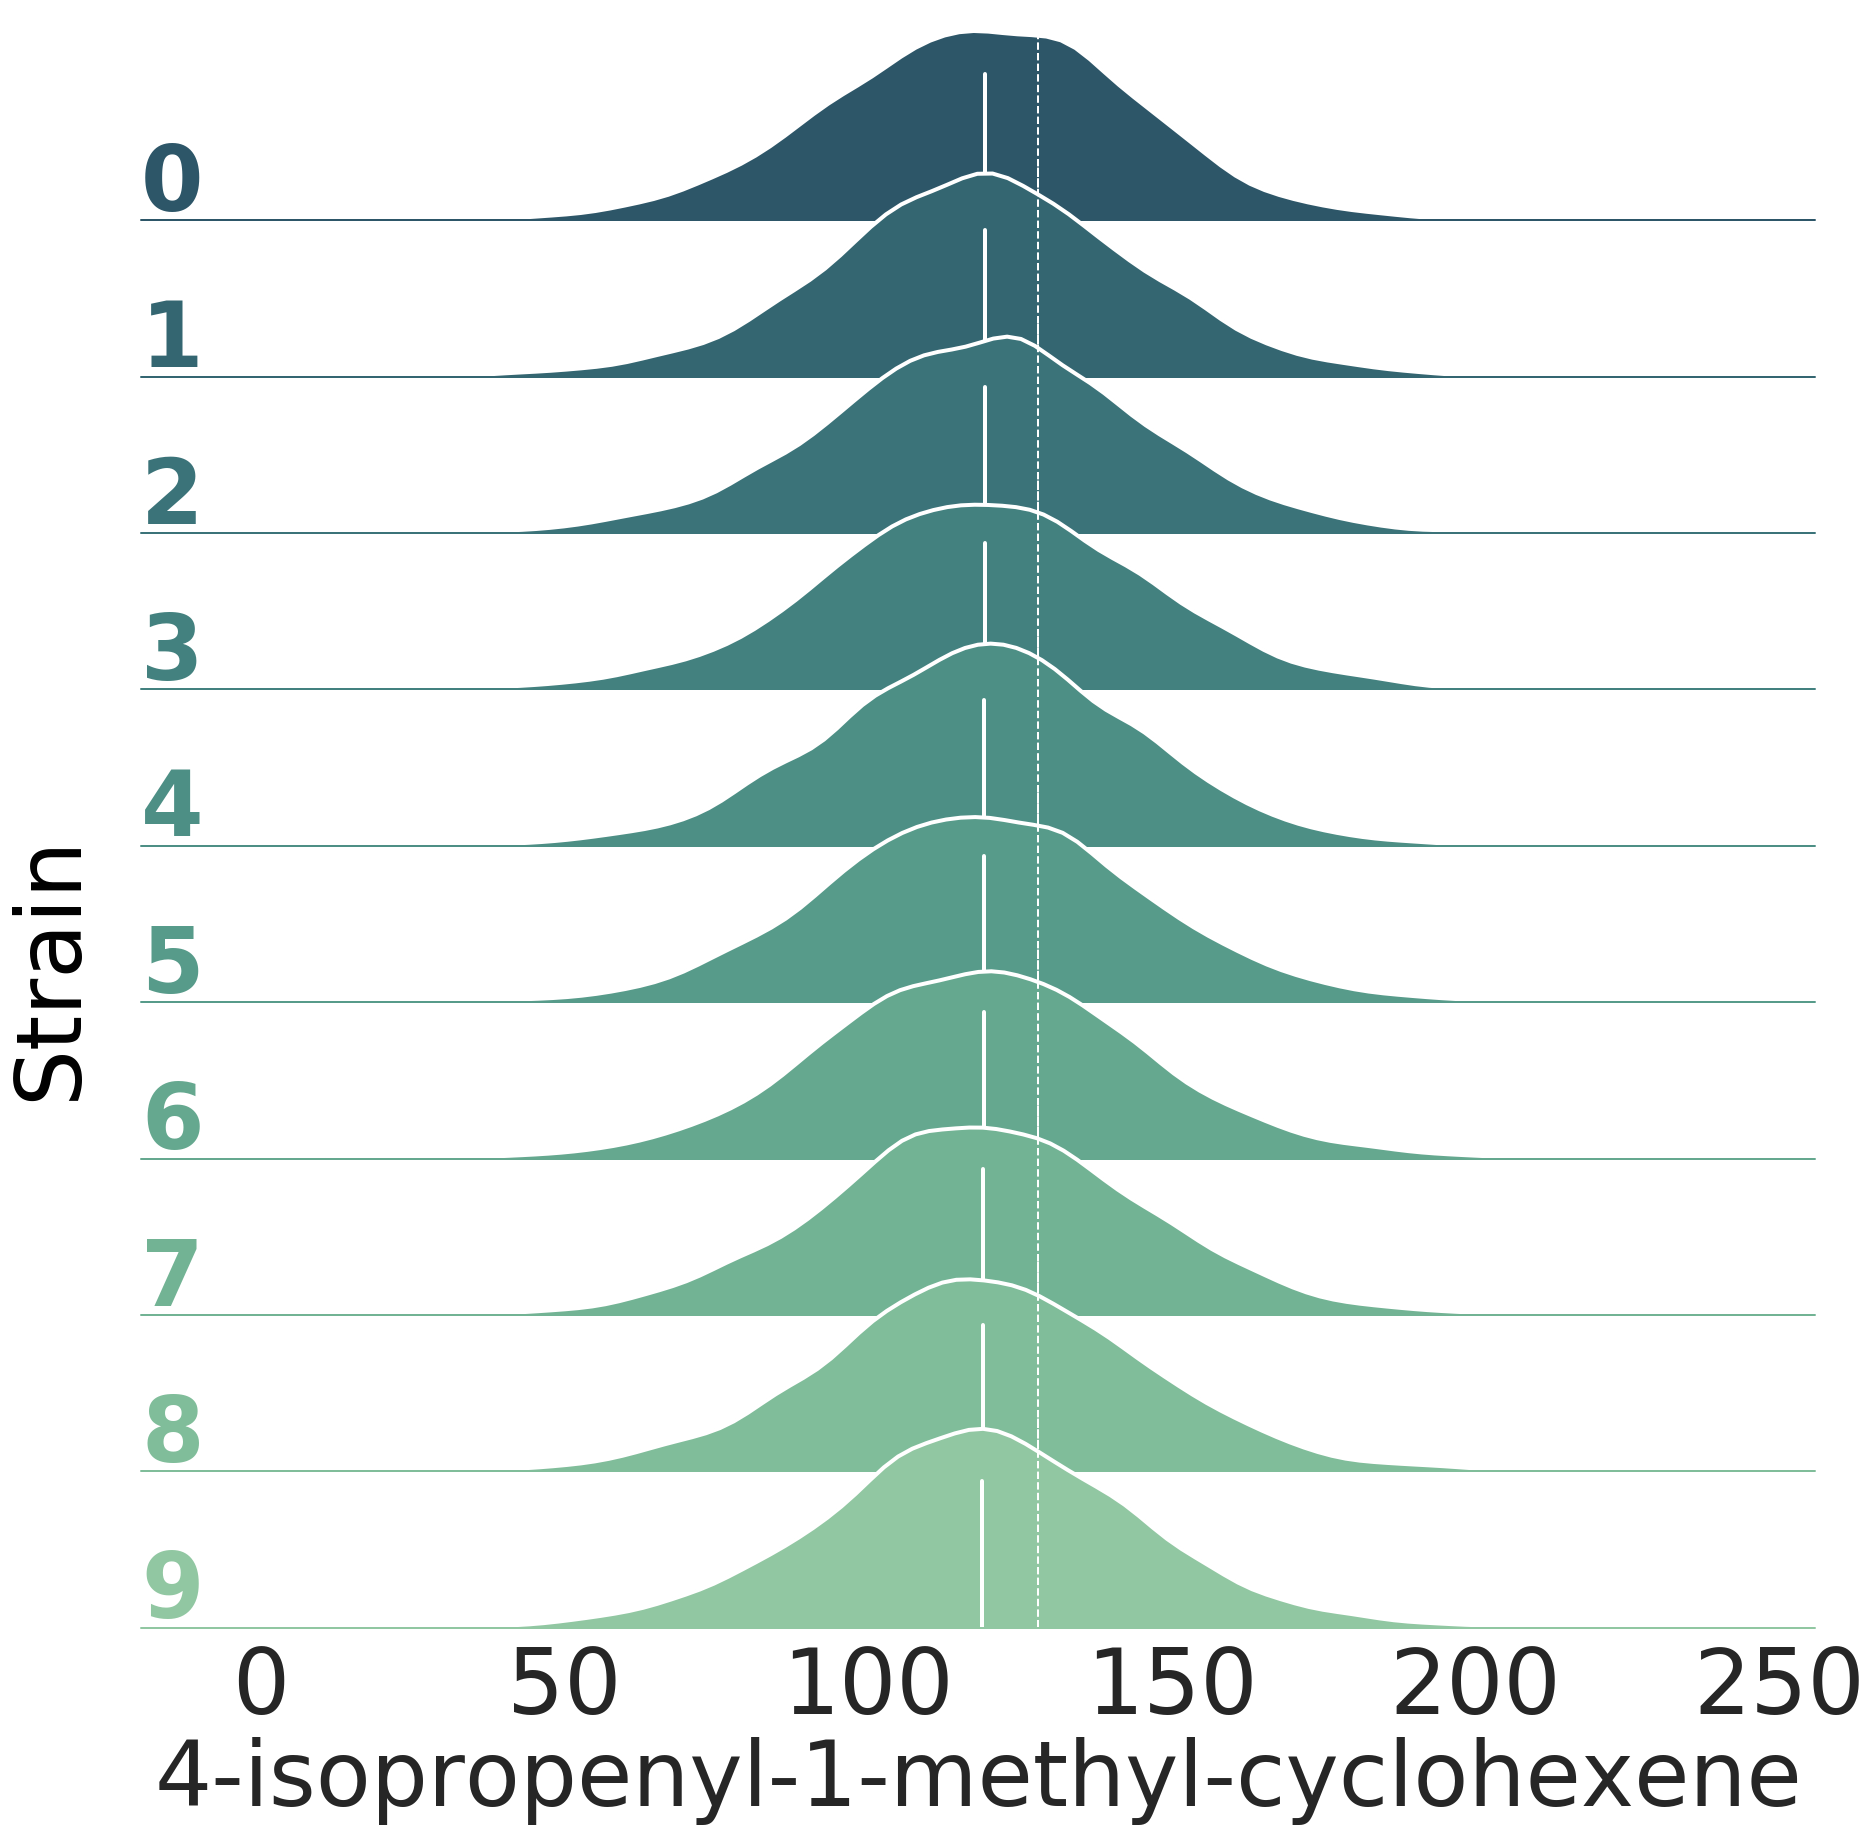

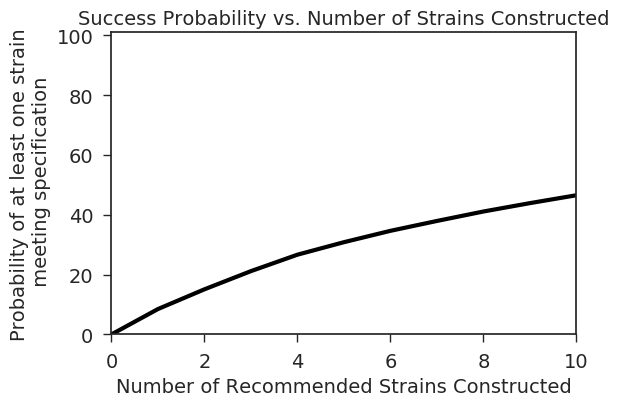

In [54]:
art2.niter = 1000000
art2.optimize()

In [55]:
os.rename(art2.outDir + '/draws.txt',
          art2.outDir + '/draws_C2.txt')
os.rename(art2.outDir + '/recommendations.csv',
          art2.outDir + '/recommendations_C2.csv')

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


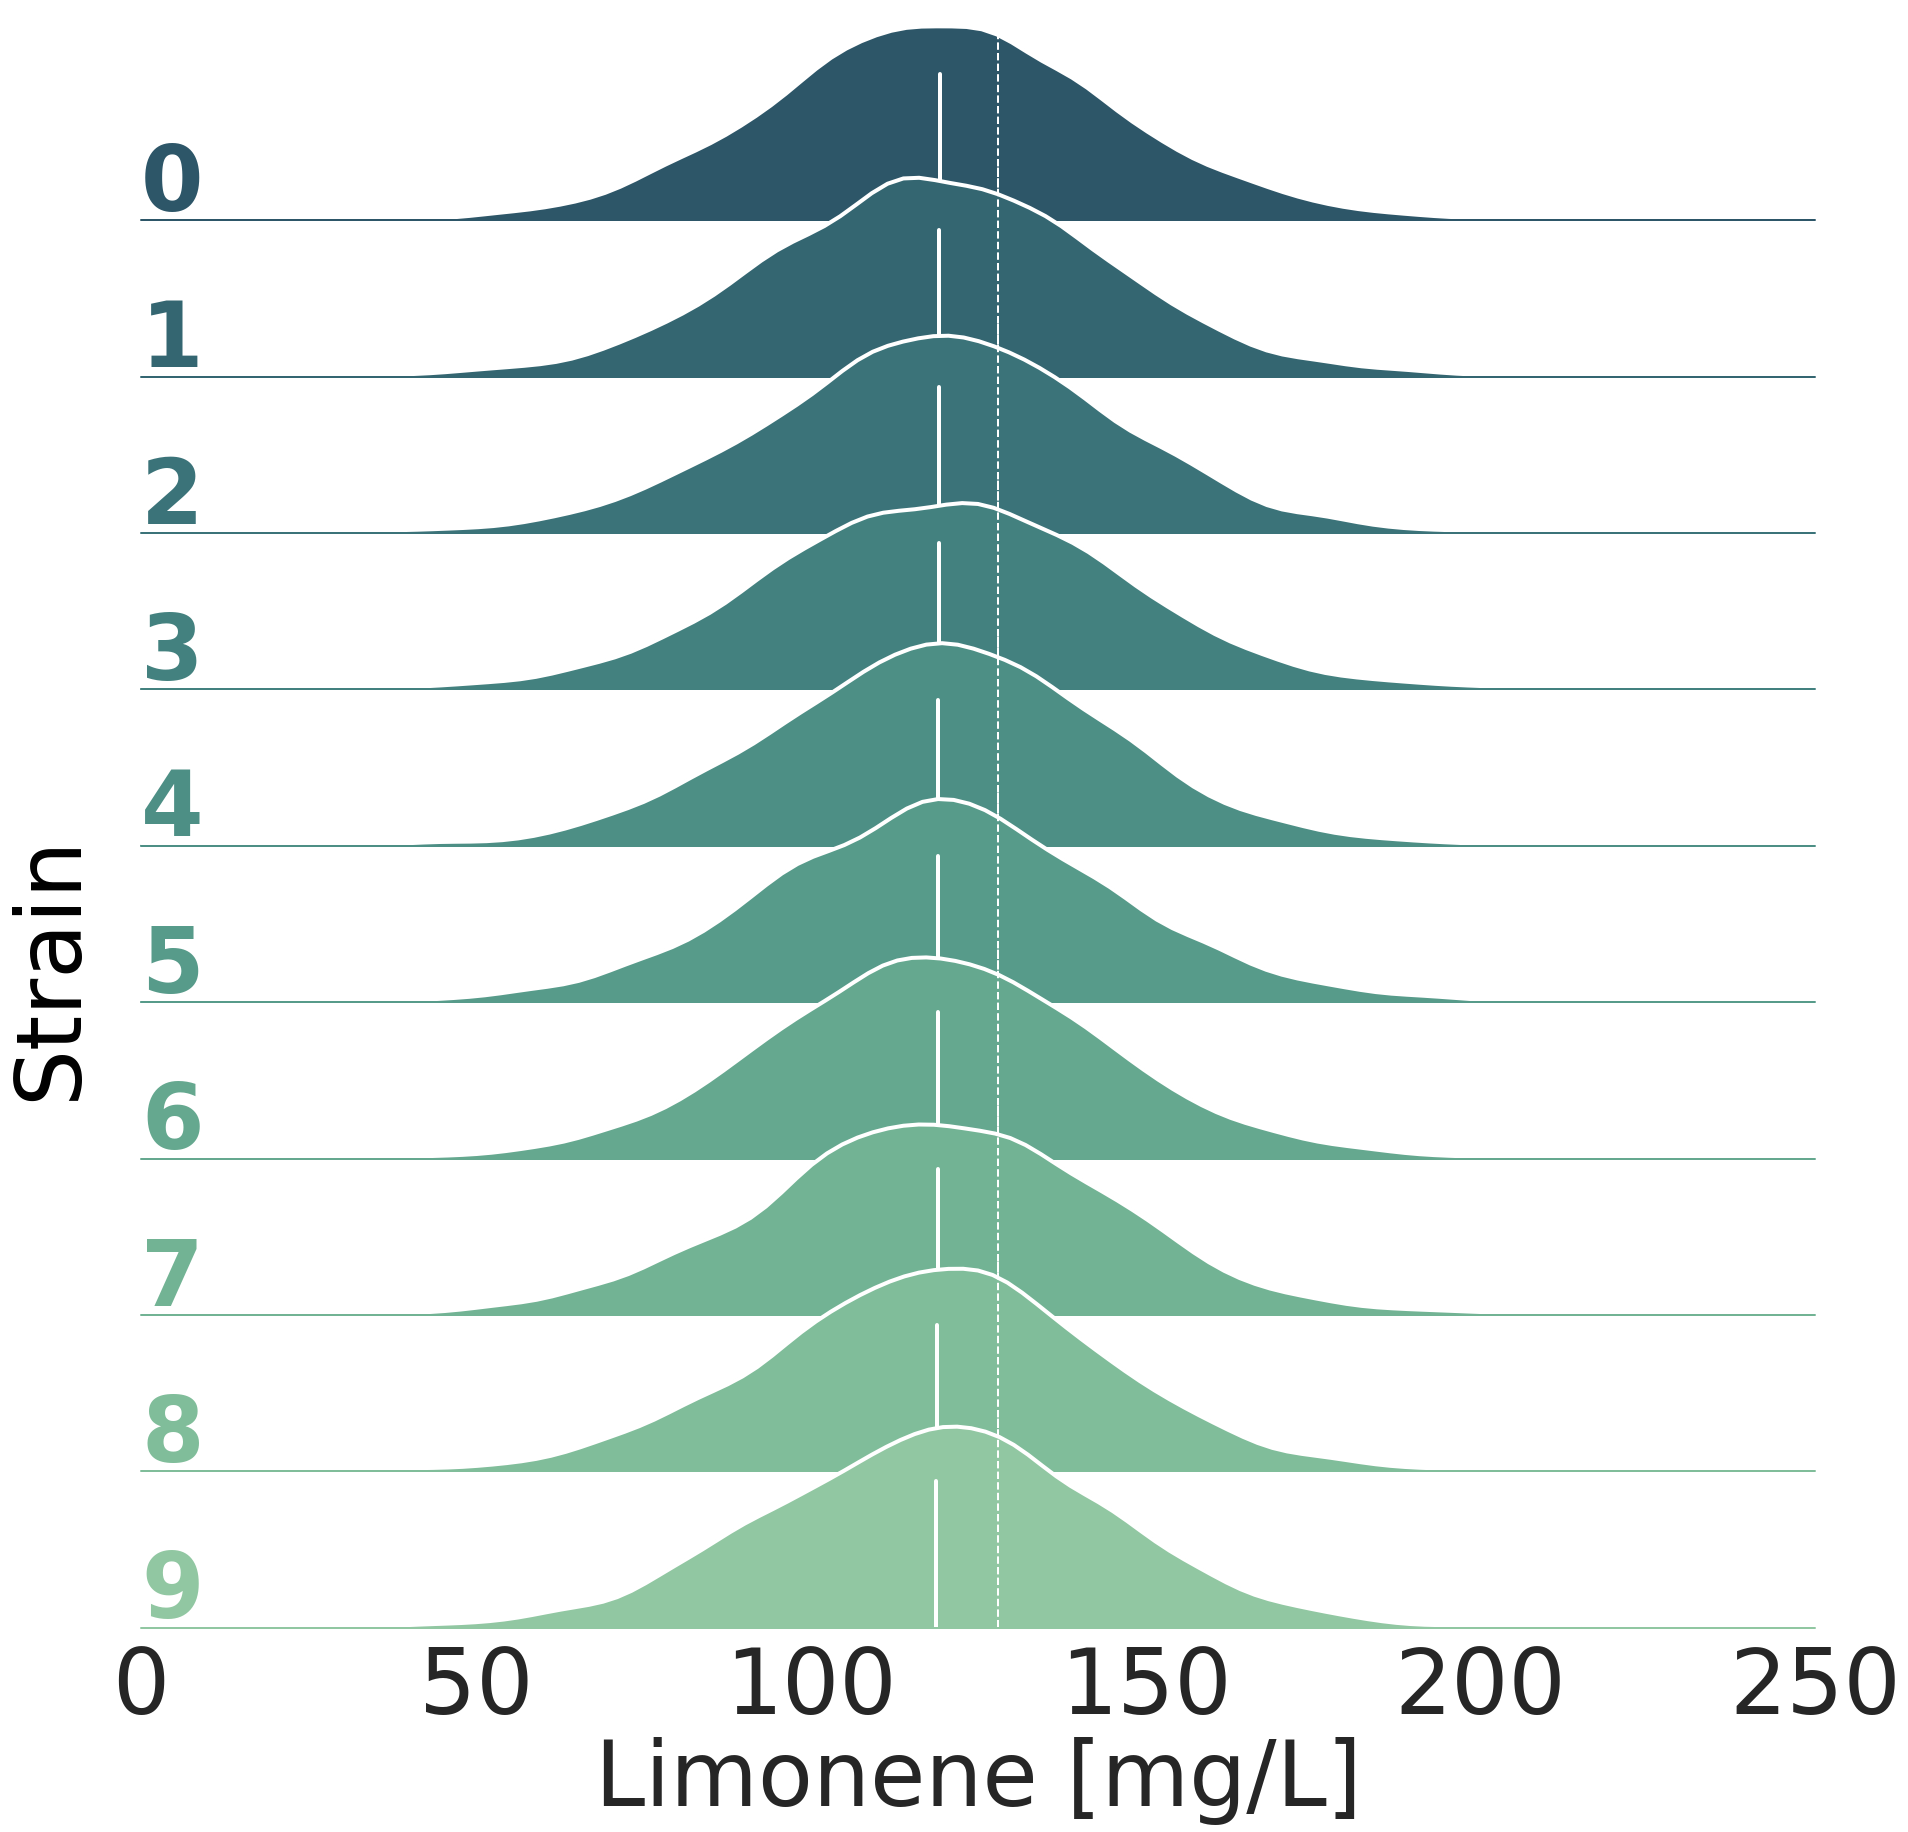

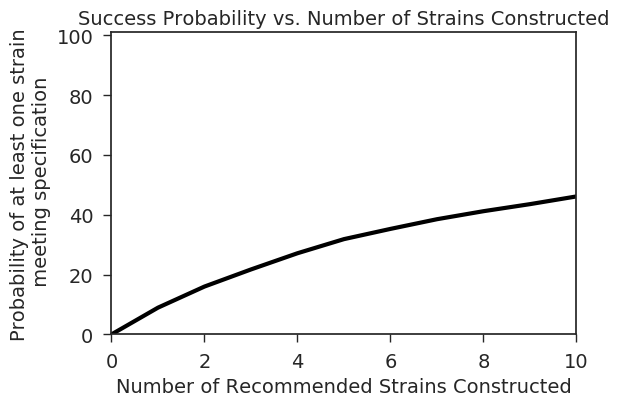

In [56]:
plot.recomm_distribution(art2, art2.find_current_best(), ['Limonene [mg/L]'], [0, 250])
cumulative_success_prob = art2.calculate_success_prob(current_best=art2.find_current_best())
plot.success_prob(art2, cumulative_success_prob)

In [57]:
os.rename(art2.outDir + '/recommendations_distribution_0.png',
          art2.outDir + '/recommendations_distribution_C2.png')
os.rename(art2.outDir + '/success_probability_' + art2.response_vars[0] + '.png',
          art2.outDir + '/success_probability_' + art2.response_vars[0] + '_C2.png')

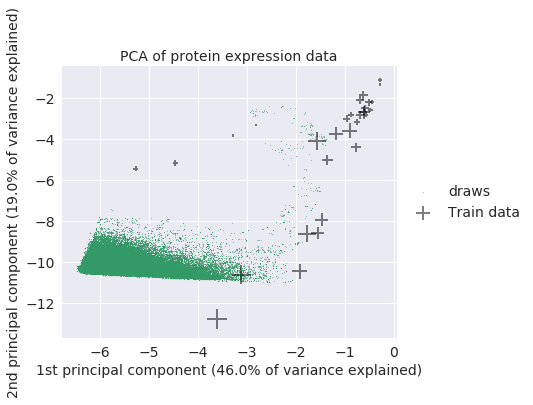

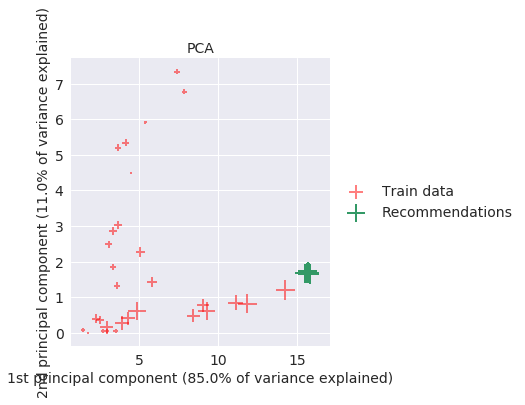

In [58]:
plot.draws_pc(art2, draws, scale=3, plot_draws=True, plot_kde=False)
plot.recommendations_pc(art2, scale=3)


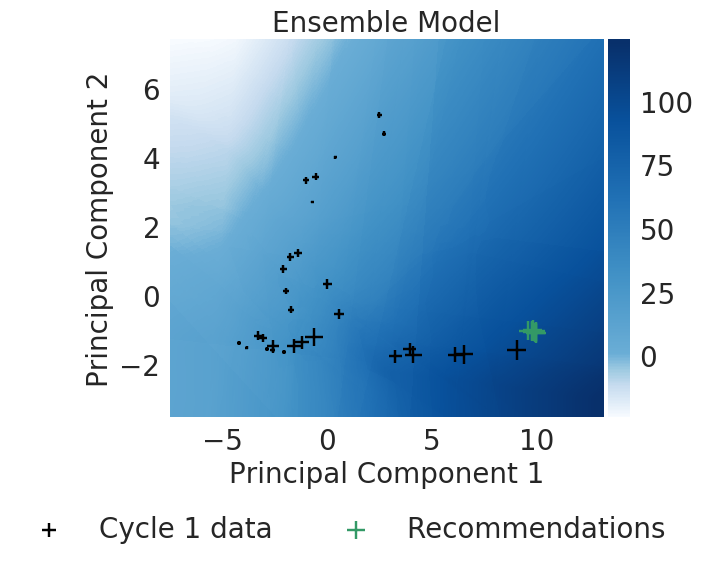

In [59]:
model = art2
plot.plot_model(model, art2, scaling_factor=1.5,
                midpoint=0.6, test_y=[],
                title='Ensemble Model', plot_points=True)

In [60]:
os.rename(art2.outDir + '/Ensemble Model_model.png',
          art2.outDir + '/Ensemble Model_model_C2.png')

In [61]:
utils.save_pkl_object(art2)
os.rename(art2.outDir + '/art.pkl', art2.outDir + '/art_C2.pkl')